In [36]:
import matplotlib.font_manager as fm
import os
import requests

# URL of the .bib file on GitHub
bib_url = "https://raw.githubusercontent.com/pjgba/FSDS/main/FSDS-citations.bib"

# Local file name
bib_file = "FSDS-citations.bib"

# Download the file if it doesn't already exist or update if outdated
if not os.path.exists(bib_file):
    print(f"Downloading {bib_file} from GitHub...")
    response = requests.get(bib_url)
    if response.status_code == 200:
        with open(bib_file, "w") as file:
            file.write(response.text)
        print(f"Downloaded {bib_file} successfully.")
    else:
        print(f"Failed to download {bib_file}. HTTP status code: {response.status_code}")
else:
    print(f"{bib_file} already exists. Skipping download.")


# List of font URLs and corresponding font names
fonts = {
    "Spectral": "https://fonts.googleapis.com/css2?family=Spectral&display=swap",
    "Roboto": "https://fonts.googleapis.com/css2?family=Roboto&display=swap",
    "JetBrains Mono": "https://fonts.googleapis.com/css2?family=JetBrains+Mono&display=swap"
}

# Function to check if a font is available
def check_font_availability(font_name):
    available_fonts = fm.findSystemFonts(fontpaths=None, fontext='ttf')
    for font_path in available_fonts:
        if font_name.lower() in font_path.lower():
            return True
    return False

# Function to download fonts if missing
def download_font(font_name, font_url):
    font_file = f"{font_name}.zip"
    print(f"Downloading {font_name} font...")
    
    # Check if the font folder exists
    font_folder = "/tmp/fonts"  # You can choose your target directory
    if not os.path.exists(font_folder):
        os.makedirs(font_folder)
    
    # Download the font
    response = requests.get(font_url)
    with open(f"{font_folder}/{font_file}", "wb") as f:
        f.write(response.content)
    print(f"{font_name} font downloaded and saved to {font_folder}.")

# Check and download fonts
for font, url in fonts.items():
    if check_font_availability(font):
        print(f"{font} is already installed.")
    else:
        print(f"{font} is not found. Downloading...")
        download_font(font, url)



FSDS-citations.bib already exists. Skipping download.
Spectral is not found. Downloading...
Spectral font downloaded and saved to /tmp/fonts.
Roboto is not found. Downloading...
Roboto font downloaded and saved to /tmp/fonts.
JetBrains Mono is not found. Downloading...
JetBrains Mono font downloaded and saved to /tmp/fonts.


In [1]:
import pandas as pd
import os
import requests
import gzip
import io
import geopandas as gpd
from shapely.geometry import Point
from tabulate import tabulate
import re

# List of datasets to process
datasets = [
    {
        "url2024": "https://data.insideairbnb.com/united-kingdom/england/london/2024-09-06/visualisations/listings.csv",
        "file_name": "Airbnb-listings-2024.csv",
        "dataset_name": "Airbnb-listings-2024",
        "scrape_year": 2024
    },
    {
        "url2022": "https://orca.casa.ucl.ac.uk/~jreades/data/2022-09-10-listings.csv.gz",
        "file_name": "2022-09-10-listings.csv.gz",
        "dataset_name": "Airbnb-listings-2022",
        "scrape_year": 2022
    },
    {
        "url2023": "https://orca.casa.ucl.ac.uk/~jreades/data/2023-09-06-listings.csv.gz",
        "file_name": "2023-09-06-listings.csv.gz",
        "dataset_name": "Airbnb-listings-2023",
        "scrape_year": 2023
    }
]

# Define output directory
output_folder = os.path.join("Double-Win-Files", "Airbnb-Data")
os.makedirs(output_folder, exist_ok=True)

def download_and_load_dataset(dataset):
    """Downloads and loads a dataset into a pandas DataFrame."""
    url_key = [key for key in dataset.keys() if key.startswith("url")][0]
    url = dataset[url_key]
    file_name = dataset['file_name']
    file_path = os.path.join(output_folder, file_name)

    # Check if file already exists
    if not os.path.exists(file_path):
        print(f"Downloading {file_name} from {url}...")
        response = requests.get(url)
        response.raise_for_status()

        # Save the downloaded file 
        with open(file_path, 'wb') as f:
            f.write(response.content)
    else:
        print(f"{file_name} already exists. Loading from file.")

    # Load the dataset from the local file
    if file_name.endswith('.gz'):
        with gzip.open(file_path, 'rt') as gz_file:
            df = pd.read_csv(gz_file, low_memory=False)
    else:
        df = pd.read_csv(file_path, low_memory=False)

    return df

def clean_dataset(df):
    """
    Cleans the dataset by removing duplicates, rows with blanks in required columns,
    and ensuring proper data types with defaults where needed.
    """
    # Define expected data types and default values for each column
    dtype_mapping = {
        'id': ('Int64', 0),
        'host_id': ('Int64', 0),
        'latitude': ('float64', 0.0),
        'longitude': ('float64', 0.0),
        'last_review': ('string', '01/01/1970'),
        'availability_365': ('Int64', 0),
        'room_type': ('string', 'unknown')
    }

    required_columns = dtype_mapping.keys()

    # Ensure only the required columns are considered
    df = df[list(required_columns)]

    # Remove rows with blanks (NaN) in any of the required columns
    df = df.dropna(subset=required_columns, how='any')

    # Remove duplicate rows
    df = df.drop_duplicates()

    # Process each column according to its expected data type and default value
    for col, (expected_type, default_value) in dtype_mapping.items():
        if col == 'last_review':
            df[col] = pd.to_datetime(df[col], errors='coerce').fillna(pd.Timestamp(default_value)).dt.strftime('%d/%m/%Y')
        elif col == 'room_type':
            df[col] = df[col].astype('string').fillna(default_value)
        else:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(default_value).astype(expected_type)

    return df

def process_and_save_dataset(dataset):
    """Processes a dataset, cleans it, and saves only specific columns."""
    try:
        df = download_and_load_dataset(dataset)

        # Clean the dataset
        df = clean_dataset(df)

        # Add scrape_year column
        df['scrape_year'] = dataset['scrape_year']

        # Construct the output file name using `dataset_name`
        output_file = os.path.join(output_folder, f"{dataset['dataset_name']}_processed.csv")
        df.to_csv(output_file, index=False)

        print(f"Processed and saved: {output_file}")

    except Exception as e:
        print(f"An error occurred while processing {dataset['dataset_name']}: {e}")

# Process each dataset
for dataset in datasets:
    process_and_save_dataset(dataset)

# Download or verify the shapefile exists
shapefile_url = "https://api.os.uk/downloads/v1/products/BoundaryLine/downloads?area=GB&format=ESRI%C2%AE+Shapefile&redirect"
download_folder = os.path.join("Double-Win-Files", "UK-Borough-Boundary-Data")
shapefile_dir = os.path.join(download_folder, "Data/GB")
shapefile_path = os.path.join(shapefile_dir, "district_borough_unitary_region.shp")

def download_shapefile(url, download_dir, shapefile_path):
    # Check if the directory exists, create it if not
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)
        print(f"Created directory: {download_dir}")
    
    # Check if the shapefile already exists
    if os.path.exists(shapefile_path):
        print(f"Shapefile already exists at {shapefile_path}")
        return shapefile_path
    
    # Download the data
    print(f"Downloading shapefile from {url}...")
    response = requests.get(url, stream=True)
    response.raise_for_status()
    
    # Save the zip file
    zip_file_path = os.path.join(download_dir, "BoundaryLine.zip")
    with open(zip_file_path, "wb") as f:
        f.write(response.content)
    print(f"Downloaded and saved as {zip_file_path}")
    
    # Extract the zip file
    import zipfile
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(download_dir)
    print(f"Extracted shapefile to {download_dir}")
    
    # Return path to shapefile
    return shapefile_path

shapefile_path = download_shapefile(shapefile_url, download_folder, shapefile_path)

# Load the shapefile into a GeoDataFrame
shapefile_gdf = gpd.read_file(shapefile_path)

lbo_gdf = shapefile_gdf[shapefile_gdf['AREA_CODE'] == 'LBO']

def filter_airbnb_by_boroughs(df, shapefile_gdf):
    """Filters Airbnb data by checking if the points are within the London Boroughs."""
    # Convert the DataFrame to a GeoDataFrame based on latitude and longitude
    df_gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326"
    )

    # Reproject the Airbnb GeoDataFrame to match the shapefile's CRS (EPSG:27700)
    df_gdf = df_gdf.to_crs(epsg=27700)

    # Reproject the shapefile GeoDataFrame to EPSG:27700 if not already in that CRS
    shapefile_gdf = shapefile_gdf.to_crs(epsg=27700)

    # Use union_all() instead of unary_union to get all the borough polygons combined
    borough_union = shapefile_gdf.geometry.union_all()

    # Add Borough column by checking within which borough the point is located
    borough_names = []
    for _, row in df_gdf.iterrows():
        borough_name = shapefile_gdf[shapefile_gdf.geometry.contains(row['geometry'])]['NAME'].values
        borough_names.append(borough_name[0] if borough_name.size > 0 else 'Unknown')

    df_gdf['Borough'] = borough_names

    # Remove 'London Boro' using regex
    df_gdf['Borough'] = df_gdf['Borough'].apply(lambda x: re.sub(r'\s*London\s*Boro\s*', '', x, flags=re.IGNORECASE))

    # Replace specific borough names
    df_gdf['Borough'] = df_gdf['Borough'].replace({
        'City and County of the City of London': 'City of London',
        'City of Westminster': 'Westminster'
    })

    # Drop the geometry column, as we no longer need it
    df_gdf = df_gdf.drop(columns=['geometry'])

    return df_gdf, shapefile_gdf

def combine_processed_datasets(input_folder, output_file, shapefile_gdf):
    """Combines all processed datasets into a single DataFrame, filters by London Boroughs, and saves it."""
    all_files = [
        f"{dataset['dataset_name']}_processed.csv" for dataset in datasets
    ]

    combined_df = pd.DataFrame()

    for file in all_files:
        file_path = os.path.join(input_folder, file)
        print(f"Loading {file_path}...")

        # Load the dataset and add a source column
        df = pd.read_csv(file_path)
        print(f"Columns in {file_path}: {df.columns}")

        # Filter the data to only include listings within London Boroughs and add the Borough column
        filtered_df, _ = filter_airbnb_by_boroughs(df, shapefile_gdf)

        # Debug: Check columns in filtered DataFrame
        print(f"Columns in filtered_df: {filtered_df.columns}")
        
        combined_df = pd.concat([combined_df, filtered_df], ignore_index=True)

    # Debug: Check columns before applying room_type filter
    print("Columns in combined DataFrame before filtering:", combined_df.columns)

    if 'room_type' not in combined_df.columns:
        print("Error: 'room_type' column is missing in combined DataFrame!")
    else:
        combined_df = combined_df[combined_df['room_type'] == 'Entire home/apt']

    # Print the first few rows of combined_df to verify its content
    print("First few rows of combined_df:")
    print(combined_df.head())

    # Save the combined dataset
    combined_df.to_csv(output_file, index=False)
    return combined_df

# Define output file for the combined dataset
output_combined_file = os.path.join(output_folder, "Airbnb_combined_dataset.csv")

# Combine and filter datasets, then save the result
combined_df = combine_processed_datasets(output_folder, output_combined_file, lbo_gdf)


Processed and saved: Double-Win-Files/Airbnb-Data/Airbnb-listings-2024_processed.csv
Processed and saved: Double-Win-Files/Airbnb-Data/Airbnb-listings-2022_processed.csv
Processed and saved: Double-Win-Files/Airbnb-Data/Airbnb-listings-2023_processed.csv
Created directory: Double-Win-Files/UK-Borough-Boundary-Data
Downloaded and saved as Double-Win-Files/UK-Borough-Boundary-Data/BoundaryLine.zip
Extracted shapefile to Double-Win-Files/UK-Borough-Boundary-Data
Loading Double-Win-Files/Airbnb-Data/Airbnb-listings-2024_processed.csv...
Columns in Double-Win-Files/Airbnb-Data/Airbnb-listings-2024_processed.csv: Index(['id', 'host_id', 'latitude', 'longitude', 'last_review',
       'availability_365', 'room_type', 'scrape_year'],
      dtype='object')
Columns in filtered_df: Index(['id', 'host_id', 'latitude', 'longitude', 'last_review',
       'availability_365', 'room_type', 'scrape_year', 'Borough'],
      dtype='object')
Loading Double-Win-Files/Airbnb-Data/Airbnb-listings-2022_processe

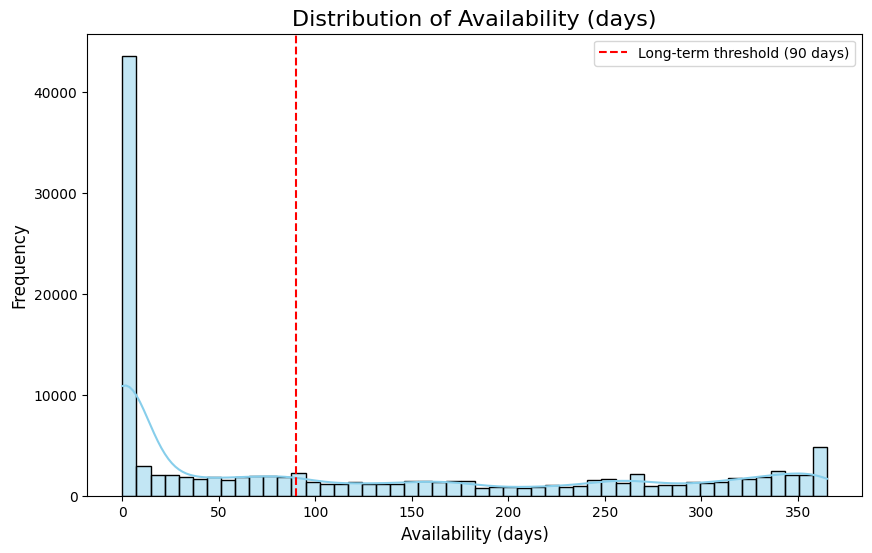

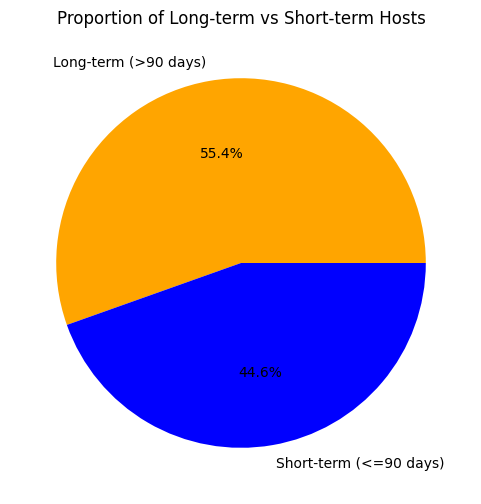

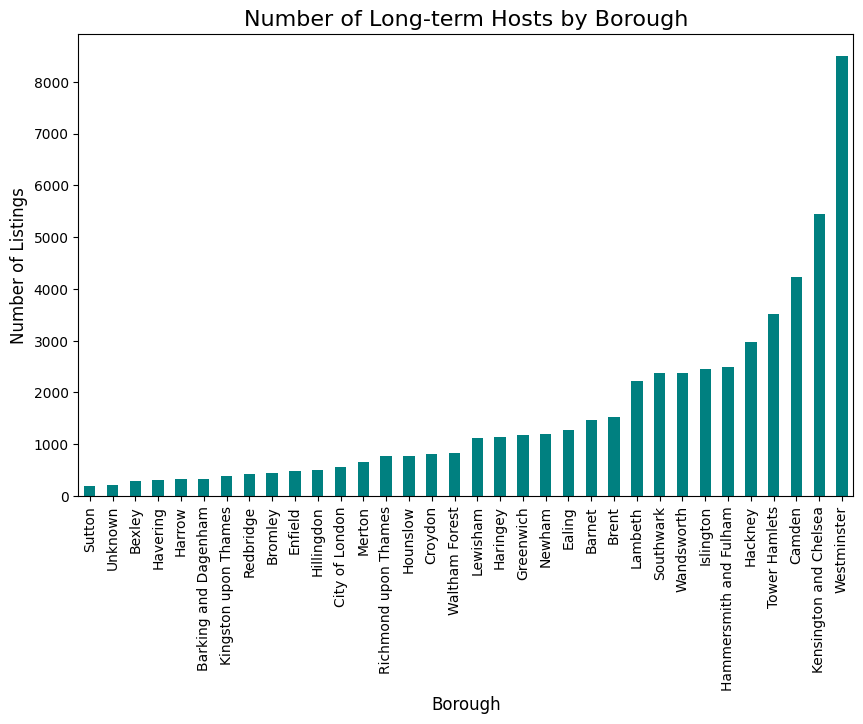

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Categorize into long-term and short-term hosts
combined_df['is_long_term'] = combined_df['availability_365'] > 90

# 1. Histogram to show distribution of availability_365
plt.figure(figsize=(10, 6))
sns.histplot(combined_df['availability_365'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Availability (days)', fontsize=16)
plt.xlabel('Availability (days)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(90, color='red', linestyle='--', label='Long-term threshold (90 days)')
plt.legend()
plt.show()

# 2. Proportion of professional vs non-professional hosts
proportion = combined_df['is_long_term'].value_counts(normalize=True) * 100
plt.figure(figsize=(6, 6))
proportion.plot(kind='pie', labels=['Long-term (>90 days)', 'Short-term (<=90 days)'], 
                autopct='%1.1f%%', colors=['orange', 'blue'])
plt.title('Proportion of Long-term vs Short-term Hosts')
plt.ylabel('')  # Hide y-axis label
plt.show()

# 3. Geographic Visualization: Grouping long-term hosts by borough
long_term_counts = combined_df[combined_df['is_long_term']].groupby('Borough')['id'].count().sort_values()
plt.figure(figsize=(10, 6))
long_term_counts.plot(kind='bar', color='teal')
plt.title('Number of Long-term Hosts by Borough', fontsize=16)
plt.xlabel('Borough', fontsize=12)
plt.ylabel('Number of Listings', fontsize=12)
plt.show()


In [3]:

import pandas as pd
import os
import requests
from zipfile import ZipFile
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment, PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows
import warnings
from tabulate import tabulate

# Suppress specific UserWarning from openpyxl
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

# Define download URLs
urls = {
    "Total Working People": "https://github.com/pjgba/FSDS/raw/refs/heads/main/Total-working-people.xlsx",
    "Total Households": "https://github.com/pjgba/FSDS/raw/refs/heads/main/Total-households.xlsx"
}

# Define directory for saving files
output_dir = os.path.join("Double-Win-Files")
os.makedirs(output_dir, exist_ok=True)

# Function to download files
def download_file(url, save_path):
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded: {save_path}")
    else:
        print(f"Failed to download {url}")

# Download files
file_paths = {}
for name, url in urls.items():
    save_path = os.path.join(output_dir, f"{name.replace(' ', '_')}.xlsx")
    download_file(url, save_path)
    file_paths[name] = save_path

# Function to clean and process data
def process_file(file_path):
    df = pd.read_excel(file_path, engine='openpyxl', header=7)
    df.columns = df.columns.astype(str)  # Convert column names to strings
    df = df.iloc[:34]
    df.reset_index(drop=True, inplace=True)
    return df

# Process each file
data = {key: process_file(path) for key, path in file_paths.items()}

# Extract relevant data
working_people_df = data["Total Working People"]
households_df = data["Total Households"]

# Rename columns appropriately
working_people_df.rename(columns={
    "local authority: district / unitary (as of April 2023)": "Borough",
    "Economically active (excluding full-time students)": "Total Working People"
}, inplace=True)

households_df.rename(columns={
    "local authority: district / unitary (as of April 2023)": "Borough",
    "2021": "Total Households"
}, inplace=True)

# Merge on 'Borough'
merged_df = pd.merge(
    working_people_df[["Borough", "Total Working People"]],
    households_df[["Borough", "Total Households"]],
    on="Borough"
)

# Convert relevant columns to numeric
numeric_columns = ["Total Working People", "Total Households"]
merged_df[numeric_columns] = merged_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Add the new calculated column
merged_df["Average wp per household"] = (
    merged_df["Total Working People"] / merged_df["Total Households"]
)

# Save the result
output_file = os.path.join(output_dir, "Combined_Data.xlsx")
merged_df.to_excel(output_file, index=False)

# Apply styles
def apply_styles(file_path):
    wb = Workbook()
    ws = wb.active

    # Load existing data
    for r in dataframe_to_rows(merged_df, index=False, header=True):
        ws.append(r)

    # Apply styles
    for cell in ws["1:1"]:
        cell.font = Font(bold=True, color="FFFFFF")
        cell.fill = PatternFill(start_color="4F81BD", end_color="4F81BD", fill_type="solid")
        cell.alignment = Alignment(horizontal="center", vertical="center")

    wb.save(file_path)
    print(f"Styled data saved to {file_path}")

# Apply styles to the saved Excel file
apply_styles(output_file)

# Additional code for downloading and processing income data
income_data_urls = {
    "2024": "https://www.ons.gov.uk/file?uri=/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/placeofresidencebylocalauthorityashetable8/2024provisional/ashetable82024provisional.zip",
    "2023": "https://www.ons.gov.uk/file?uri=/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/placeofresidencebylocalauthorityashetable8/2023revised/ashetable82023revised.zip",
    "2022": "https://www.ons.gov.uk/file?uri=/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/placeofresidencebylocalauthorityashetable8/2022revised/ashetable82022revised.zip"
}

# Define directories for downloading and extracting data
double_win_folder = os.path.join("Double-Win-Files")
income_data_folder = os.path.join("Double-Win-Files", "Average-Income-Data")
os.makedirs(income_data_folder, exist_ok=True)

# Function to download and extract income data
def download_and_extract_income_data(url, year):
    zip_file_path = os.path.join(income_data_folder, f"ashe_table_{year}.zip")
    extract_folder = os.path.join(income_data_folder, f"ashe_{year}")
    
    # Download the dataset if not already downloaded
    if not os.path.exists(zip_file_path):
        print(f"Downloading {year} income data...")
        response = requests.get(url)
        response.raise_for_status()  # Will raise an exception for bad responses (4xx/5xx)
        
        # Save the downloaded content to the zip file
        with open(zip_file_path, "wb") as f:
            f.write(response.content)
        print(f"Downloaded {year} data to {zip_file_path}")
    else:
        print(f"{year} data already downloaded.")
    
    # Verify the downloaded file is a valid ZIP before extracting
    if not zip_file_path.endswith(".zip"):
        raise RuntimeError(f"The downloaded file for {year} is not a ZIP file.")
    
    # Extract the dataset if not already extracted
    if not os.path.exists(extract_folder):
        print(f"Extracting {year} income data...")
        try:
            with ZipFile(zip_file_path, "r") as zip_ref:
                zip_ref.extractall(extract_folder)
            print(f"Extracted {year} data to {extract_folder}")
        except Exception as e:
            raise RuntimeError(f"Failed to extract {year} ZIP file: {e}")
    
    # List all extracted files for debugging
    extracted_files = []
    for root, _, files in os.walk(extract_folder):
        extracted_files.extend(files)
    
    # Look for file containing "8.7a" in its name
    for file in extracted_files:
        if "8.7a" in file.lower() and file.endswith((".xlsx", ".xls")):
            return os.path.join(root, file)
    
    raise FileNotFoundError(f"Expected Excel file not found for {year}")

# Function to clean income data
def clean_income_data(file_path, year):
    print(f"Cleaning data for {year}...")
    
    # Load the Excel sheet "All" and select the required columns
    df = pd.read_excel(file_path, sheet_name="All", header=4, usecols=["Description", "Median"])
    
    # Remove leading/trailing spaces in the Description column
    df["Description"] = df["Description"].str.strip()
    
    # Remove commas from Median column, then convert to numeric
    df["Median"] = df["Median"].replace({',': ''}, regex=True)
    df["Median"] = pd.to_numeric(df["Median"], errors="coerce")
    
    # Define the list of boroughs (cleaned of extra spaces)
    london_boroughs = [
        "City of London", "Camden", "Hackney", "Hammersmith and Fulham",
        "Haringey", "Islington", "Kensington and Chelsea", "Lambeth",
        "Lewisham", "Newham", "Southwark", "Tower Hamlets", "Wandsworth",
        "Westminster", "Barking and Dagenham", "Barnet", "Bexley", "Brent",
        "Bromley", "Croydon", "Ealing", "Enfield", "Greenwich", "Harrow",
        "Havering", "Hillingdon", "Hounslow", "Kingston upon Thames",
        "Merton", "Redbridge", "Richmond upon Thames", "Sutton",
        "Waltham Forest"
    ]
    
    # Filter for rows corresponding to London boroughs
    df = df[df["Description"].isin(london_boroughs)]
    
    # Add a Year column
    df["Year"] = int(year)
    
    return df

# Function to combine all data into a single DataFrame
def process_all_years_data():
    all_data = []  # List to store cleaned data for all years
    df_2024 = df_2023 = df_2022 = None

    for year, url in income_data_urls.items():
        # Step 1: Download and extract data
        file_path = download_and_extract_income_data(url, year)
        
        # Step 2: Clean the extracted data
        year_data = clean_income_data(file_path, year)
        
        # Step 3: Store the cleaned data in appropriate DataFrame variables
        if year == "2024":
            df_2024 = year_data
        elif year == "2023":
            df_2023 = year_data
        elif year == "2022":
            df_2022 = year_data
        
        # Step 4: Append the cleaned data to the list
        all_data.append(year_data)

    # Check that all years were processed successfully
    if df_2024 is None or df_2023 is None or df_2022 is None:
        raise ValueError("One or more years were not processed correctly.")
    
    # Step 5: Combine all cleaned data into a single DataFrame
    combined_data = pd.concat(all_data, ignore_index=True)
    
    # Step 6: Sort the data by Description (borough) and Year
    combined_data = combined_data.sort_values(by=["Description", "Year"]).reset_index(drop=True)
    
    # Step 7: Standardize Description column (strip whitespace)
    combined_data["Description"] = combined_data["Description"].str.strip()
    
    # Step 8: Manually replace NaN values in the DataFrames
    # Replace values for the 2024 DataFrame (City of London)
    combined_data.loc[(combined_data['Description'] == 'City of London') & (combined_data['Year'] == 2024), 'Median'] = 61320
    
    # Replace values for the 2023 DataFrame (City of London)
    combined_data.loc[(combined_data['Description'] == 'City of London') & (combined_data['Year'] == 2023), 'Median'] = 58400
    
    # Replace values for the 2022 DataFrame (City of London)
    combined_data.loc[(combined_data['Description'] == 'City of London') & (combined_data['Year'] == 2022), 'Median'] = 56783.6
    
    # Replace values for the 2023 DataFrame (Harrow)
    combined_data.loc[(combined_data['Description'] == 'Harrow') & (combined_data['Year'] == 2023), 'Median'] = 34414.3
    
    # Replace values for the 2023 DataFrame (Richmond upon Thames)
    combined_data.loc[(combined_data['Description'] == 'Richmond upon Thames') & (combined_data['Year'] == 2023), 'Median'] = 37699.3
    
    # Replace values for the 2022 DataFrame (Hackney)
    combined_data.loc[(combined_data['Description'] == 'Hackney') & (combined_data['Year'] == 2022), 'Median'] = 42131.4

    # Step 9: Save the combined data to the same folder as the datasets
    combined_file_path = os.path.join(income_data_folder, "combined_average_income_data.csv")
    combined_data.to_csv(combined_file_path, index=False)
    print(f"Combined data saved to {combined_file_path}")
    
    return combined_data

# Main script execution
if __name__ == "__main__":
    combined_data = process_all_years_data()

    # Merge and calculate Average Household Income
    def merge_and_calculate_income(merged_df, combined_data):
        # Create a mapping from Borough to Average wp per household
        borough_to_avg_wp = merged_df.set_index('Borough')['Average wp per household'].to_dict()

        # Map the average wp per household to the combined data
        combined_data['Average wp per household'] = combined_data['Description'].map(borough_to_avg_wp)

        # Calculate the Average Household Income
        combined_data['Average Household Income'] = combined_data['Median'] * combined_data['Average wp per household']

        # Keep only the required columns
        combined_data = combined_data[['Description', 'Year', 'Average Household Income']]

        # Round the Average Household Income to 2 decimal places
        combined_data.loc[:, 'Average Household Income'] = combined_data['Average Household Income'].round(2)

        # Save the updated combined data
        updated_file_path = os.path.join(income_data_folder, "combined_data_with_income.csv")
        combined_data.to_csv(updated_file_path, index=False)
        print(f"Updated combined data saved to {updated_file_path}")

        return combined_data

    # Execute the merge and calculation
    updated_combined_data = merge_and_calculate_income(merged_df, combined_data)
    
    # Print the final DataFrame as a pretty table
    print("Updated Combined Data Preview:")
    print(tabulate(updated_combined_data.head(33), headers='keys', tablefmt='pretty'))


Downloaded: Double-Win-Files/Total_Working_People.xlsx
Downloaded: Double-Win-Files/Total_Households.xlsx
Styled data saved to Double-Win-Files/Combined_Data.xlsx
Downloaded 2024 data to Double-Win-Files/Average-Income-Data/ashe_table_2024.zip
Extracting 2024 income data...
Extracted 2024 data to Double-Win-Files/Average-Income-Data/ashe_2024
Cleaning data for 2024...
Downloaded 2023 data to Double-Win-Files/Average-Income-Data/ashe_table_2023.zip
Extracting 2023 income data...
Extracted 2023 data to Double-Win-Files/Average-Income-Data/ashe_2023
Cleaning data for 2023...
Downloaded 2022 data to Double-Win-Files/Average-Income-Data/ashe_table_2022.zip
Extracting 2022 income data...
Extracted 2022 data to Double-Win-Files/Average-Income-Data/ashe_2022
Cleaning data for 2022...
Combined data saved to Double-Win-Files/Average-Income-Data/combined_average_income_data.csv
Updated combined data saved to Double-Win-Files/Average-Income-Data/combined_data_with_income.csv
Updated Combined Data 

In [4]:

import pandas as pd
import requests
import os
import matplotlib.pyplot as plt
from tabulate import tabulate

# Directory for saving data in "Double-Win-Files"
double_win_folder = os.path.join("Double-Win-Files")  # Define the  folder
output_dir = os.path.join("Double-Win-Files", "ONS_Rental_Data")  # Final path for saving data
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# URL for ONS Figure 7 data
ons_url = "https://www.ons.gov.uk/visualisations/dvc3109/fig07/datadownload.xlsx"
file_path = os.path.join(output_dir, "figure_7_data.xlsx")

# Function to download and save dataset
def download_ons_data(url, output_file):
    if not os.path.exists(output_file):
        print(f"Downloading data from {url}...")
        response = requests.get(url)
        with open(output_file, "wb") as f:
            f.write(response.content)
        print(f"Data saved to {output_file}")
    else:
        print(f"Data already exists at {output_file}")
    return output_file

# Function to clean dataset
def clean_ons_data(file_path):
    # Load dataset
    df = pd.read_excel(file_path, header=4)  # Assuming data starts at row 5
    
    # Remove metadata rows
    df = df.rename(columns=df.iloc[2]).iloc[3:].reset_index(drop=True)
    
    # Filter for London and 2024 data
    df["Time period"] = pd.to_datetime(df["Time period"], errors="coerce")
    df = df[(df["Region or country name"] == "London") & (df["Time period"].dt.year == 2024)]
    
    # Reset index and save cleaned data
    df = df.reset_index(drop=True)
    cleaned_file = os.path.join(output_dir, "filtered_london_data_2024.csv")
    df.to_csv(cleaned_file, index=False)
    print(f"Cleaned data saved to {cleaned_file}")
    return df

# Visualization: Rental Price Trends
def visualize_rental_trends(df):
    plt.figure(figsize=(12, 6))
    for area in df["Area name"].unique():
        area_data = df[df["Area name"] == area]
        plt.plot(area_data["Time period"], area_data["Rental price (£)"], label=area)
    plt.title("Rental Price Trends in London Boroughs (2024)")
    plt.xlabel("Month")
    plt.ylabel("Rental Price (£)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Main Script Execution
if __name__ == "__main__":
    download_ons_data(ons_url, file_path)
    london_data = clean_ons_data(file_path)
    print(tabulate(london_data.head(), headers="keys", tablefmt="pretty"))


import pandas as pd
import requests
import os
from tabulate import tabulate

# Directory for saving data
output_dir = "ONS_Rental_Data"
os.makedirs(output_dir, exist_ok=True)

# URL for ONS Figure 7 data
ons_url = "https://www.ons.gov.uk/visualisations/dvc3109/fig07/datadownload.xlsx"
file_path = os.path.join(output_dir, "figure_7_data.xlsx")

# Function to download and save dataset
def download_ons_data(url, output_file):
    if not os.path.exists(output_file):
        print(f"Downloading data from {url}...")
        response = requests.get(url)
        with open(output_file, "wb") as f:
            f.write(response.content)
        print(f"Data saved to {output_file}")
    else:
        print(f"Data already exists at {output_file}")
    return output_file

# Function to clean dataset
def clean_ons_data(file_path):
    # Load dataset
    df = pd.read_excel(file_path, header=4, engine="openpyxl")  # Assuming data starts at row 5
    
    # Rename columns
    df.columns = ["Time period", "Area code", "Area name", "Region or country name", 
                  "Annual change (%)", "Rental price (£)"]
    
    # Ensure proper datetime format
    df["Time period"] = pd.to_datetime(df["Time period"], format="%Y-%m-%d", errors="coerce")
    
    # Filter for London and years 2022–2024
    df = df[(df["Region or country name"] == "London") & 
            (df["Time period"].dt.year.isin([2022, 2023, 2024]))]
    
    # Check if City of London is present
    if "City of London" not in df["Area name"].values:
        print("City of London data is missing. Adding placeholder values...")
        placeholder_data = {
            "Time period": pd.to_datetime(["2022-01-01", "2023-01-01", "2024-01-01"]),
            "Area code": ["E09000001"] * 3,
            "Area name": ["City of London"] * 3,
            "Region or country name": ["London"] * 3,
            "Annual change (%)": [None] * 3,
            "Rental price (£)": [None] * 3,  # Placeholder for missing rental price
        }
        city_of_london_df = pd.DataFrame(placeholder_data)
        df = pd.concat([df, city_of_london_df], ignore_index=True)
    
    # Reset index
    df = df.reset_index(drop=True)
    
    # Save cleaned data
    cleaned_file = os.path.join(output_dir, "filtered_london_data_2022_2024.csv")
    df.to_csv(cleaned_file, index=False)
    print(f"Cleaned data saved to {cleaned_file}")
    
    return df

# Main Script Execution
if __name__ == "__main__":
    # Download the ONS dataset
    download_ons_data(ons_url, file_path)
    
    # Clean and filter the dataset
    london_data = clean_ons_data(file_path)
    
    # Display the cleaned data
    print("Filtered London Data (2022-2024):")
    print(tabulate(london_data.head(10), headers="keys", tablefmt="pretty"))


Data saved to Double-Win-Files/ONS_Rental_Data/figure_7_data.xlsx
Cleaned data saved to Double-Win-Files/ONS_Rental_Data/filtered_london_data_2024.csv
+---+---------------------+-----------+----------------------+------------------------+-------------------+------------------+
|   |     Time period     | Area code |      Area name       | Region or country name | Annual change (%) | Rental price (£) |
+---+---------------------+-----------+----------------------+------------------------+-------------------+------------------+
| 0 | 2024-01-01 00:00:00 | E09000002 | Barking and Dagenham |         London         |        6.5        |       1382       |
| 1 | 2024-02-01 00:00:00 | E09000002 | Barking and Dagenham |         London         |         7         |       1392       |
| 2 | 2024-03-01 00:00:00 | E09000002 | Barking and Dagenham |         London         |        7.5        |       1404       |
| 3 | 2024-04-01 00:00:00 | E09000002 | Barking and Dagenham |         London         |

In [5]:


# Define download URLs
urls = {
    "Total Working People": "https://github.com/pjgba/FSDS/raw/refs/heads/main/Total-working-people.xlsx",
    "Total Households": "https://github.com/pjgba/FSDS/raw/refs/heads/main/Total-households.xlsx"
}

# Define directory for saving files
output_dir = os.path.join("Double-Win-Files")
os.makedirs(output_dir, exist_ok=True)

# Function to download files
def download_file(url, save_path):
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded: {save_path}")
    else:
        print(f"Failed to download {url}")

# Download files
file_paths = {}
for name, url in urls.items():
    save_path = os.path.join(output_dir, f"{name.replace(' ', '_')}.xlsx")
    download_file(url, save_path)
    file_paths[name] = save_path

# Function to clean and process data
def process_file(file_path):
    df = pd.read_excel(file_path, engine='openpyxl', header=7)
    df.columns = df.columns.astype(str)  # Convert column names to strings
    df = df.iloc[:34]
    df.reset_index(drop=True, inplace=True)
    return df

# Process each file
data = {key: process_file(path) for key, path in file_paths.items()}

# Extract relevant data
working_people_df = data["Total Working People"]
households_df = data["Total Households"]

# Rename columns appropriately
working_people_df.rename(columns={
    "local authority: district / unitary (as of April 2023)": "Borough",
    "Economically active (excluding full-time students)": "Total Working People"
}, inplace=True)

households_df.rename(columns={
    "local authority: district / unitary (as of April 2023)": "Borough",
    "2021": "Total Households"
}, inplace=True)

# Merge on 'Borough'
merged_df = pd.merge(
    working_people_df[["Borough", "Total Working People"]],
    households_df[["Borough", "Total Households"]],
    on="Borough"
)

# Convert relevant columns to numeric
numeric_columns = ["Total Working People", "Total Households"]
merged_df[numeric_columns] = merged_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Add the new calculated column
merged_df["Average wp per household"] = (
    merged_df["Total Working People"] / merged_df["Total Households"]
)

# Save the result
output_file = os.path.join(output_dir, "Combined_Data.xlsx")
merged_df.to_excel(output_file, index=False)

# Apply styles
def apply_styles(file_path):
    wb = Workbook()
    ws = wb.active

    # Load existing data
    for r in dataframe_to_rows(merged_df, index=False, header=True):
        ws.append(r)

    # Apply styles
    for cell in ws["1:1"]:
        cell.font = Font(bold=True, color="FFFFFF")
        cell.fill = PatternFill(start_color="4F81BD", end_color="4F81BD", fill_type="solid")
        cell.alignment = Alignment(horizontal="center", vertical="center")

    wb.save(file_path)
    print(f"Styled data saved to {file_path}")

# Apply styles to the saved Excel file
apply_styles(output_file)

# Additional code for downloading and processing income data
income_data_urls = {
    "2024": "https://www.ons.gov.uk/file?uri=/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/placeofresidencebylocalauthorityashetable8/2024provisional/ashetable82024provisional.zip",
    "2023": "https://www.ons.gov.uk/file?uri=/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/placeofresidencebylocalauthorityashetable8/2023revised/ashetable82023revised.zip",
    "2022": "https://www.ons.gov.uk/file?uri=/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/placeofresidencebylocalauthorityashetable8/2022revised/ashetable82022revised.zip"
}

# Define directories for downloading and extracting data
double_win_folder = os.path.join("Double-Win-Files")
income_data_folder = os.path.join("Double-Win-Files", "Average-Income-Data")
os.makedirs(income_data_folder, exist_ok=True)

# Function to download and extract income data
def download_and_extract_income_data(url, year):
    zip_file_path = os.path.join(income_data_folder, f"ashe_table_{year}.zip")
    extract_folder = os.path.join(income_data_folder, f"ashe_{year}")
    
    # Download the dataset if not already downloaded
    if not os.path.exists(zip_file_path):
        print(f"Downloading {year} income data...")
        response = requests.get(url)
        response.raise_for_status()  # Will raise an exception for bad responses (4xx/5xx)
        
        # Save the downloaded content to the zip file
        with open(zip_file_path, "wb") as f:
            f.write(response.content)
        print(f"Downloaded {year} data to {zip_file_path}")
    else:
        print(f"{year} data already downloaded.")
    
    # Verify the downloaded file is a valid ZIP before extracting
    if not zip_file_path.endswith(".zip"):
        raise RuntimeError(f"The downloaded file for {year} is not a ZIP file.")
    
    # Extract the dataset if not already extracted
    if not os.path.exists(extract_folder):
        print(f"Extracting {year} income data...")
        try:
            with ZipFile(zip_file_path, "r") as zip_ref:
                zip_ref.extractall(extract_folder)
            print(f"Extracted {year} data to {extract_folder}")
        except Exception as e:
            raise RuntimeError(f"Failed to extract {year} ZIP file: {e}")
    
    # List all extracted files for debugging
    extracted_files = []
    for root, _, files in os.walk(extract_folder):
        extracted_files.extend(files)
    
    # Look for file containing "8.7a" in its name
    for file in extracted_files:
        if "8.7a" in file.lower() and file.endswith((".xlsx", ".xls")):
            return os.path.join(root, file)
    
    raise FileNotFoundError(f"Expected Excel file not found for {year}")

# Function to clean income data
def clean_income_data(file_path, year):
    print(f"Cleaning data for {year}...")
    
    # Load the Excel sheet "All" and select the required columns
    df = pd.read_excel(file_path, sheet_name="All", header=4, usecols=["Description", "Median"])
    
    # Remove leading/trailing spaces in the Description column
    df["Description"] = df["Description"].str.strip()
    
    # Remove commas from Median column, then convert to numeric
    df["Median"] = df["Median"].replace({',': ''}, regex=True)
    df["Median"] = pd.to_numeric(df["Median"], errors="coerce")
    
    # Define the list of boroughs (cleaned of extra spaces)
    london_boroughs = [
        "City of London", "Camden", "Hackney", "Hammersmith and Fulham",
        "Haringey", "Islington", "Kensington and Chelsea", "Lambeth",
        "Lewisham", "Newham", "Southwark", "Tower Hamlets", "Wandsworth",
        "Westminster", "Barking and Dagenham", "Barnet", "Bexley", "Brent",
        "Bromley", "Croydon", "Ealing", "Enfield", "Greenwich", "Harrow",
        "Havering", "Hillingdon", "Hounslow", "Kingston upon Thames",
        "Merton", "Redbridge", "Richmond upon Thames", "Sutton",
        "Waltham Forest"
    ]
    
    # Filter for rows corresponding to London boroughs
    df = df[df["Description"].isin(london_boroughs)]
    
    # Add a Year column
    df["Year"] = int(year)
    
    return df

# Function to combine all data into a single DataFrame
def process_all_years_data():
    all_data = []  # List to store cleaned data for all years
    df_2024 = df_2023 = df_2022 = None

    for year, url in income_data_urls.items():
        # Step 1: Download and extract data
        file_path = download_and_extract_income_data(url, year)
        
        # Step 2: Clean the extracted data
        year_data = clean_income_data(file_path, year)
        
        # Step 3: Store the cleaned data in appropriate DataFrame variables
        if year == "2024":
            df_2024 = year_data
        elif year == "2023":
            df_2023 = year_data
        elif year == "2022":
            df_2022 = year_data
        
        # Step 4: Append the cleaned data to the list
        all_data.append(year_data)

    # Check that all years were processed successfully
    if df_2024 is None or df_2023 is None or df_2022 is None:
        raise ValueError("One or more years were not processed correctly.")
    
    # Step 5: Combine all cleaned data into a single DataFrame
    combined_data = pd.concat(all_data, ignore_index=True)
    
    # Step 6: Sort the data by Description (borough) and Year
    combined_data = combined_data.sort_values(by=["Description", "Year"]).reset_index(drop=True)
    
    # Step 7: Standardize Description column (strip whitespace)
    combined_data["Description"] = combined_data["Description"].str.strip()
    
    # Step 8: Manually replace NaN values in the DataFrames
    # Replace values for the 2024 DataFrame (City of London)
    combined_data.loc[(combined_data['Description'] == 'City of London') & (combined_data['Year'] == 2024), 'Median'] = 61320
    
    # Replace values for the 2023 DataFrame (City of London)
    combined_data.loc[(combined_data['Description'] == 'City of London') & (combined_data['Year'] == 2023), 'Median'] = 58400
    
    # Replace values for the 2022 DataFrame (City of London)
    combined_data.loc[(combined_data['Description'] == 'City of London') & (combined_data['Year'] == 2022), 'Median'] = 56783.6
    
    # Replace values for the 2023 DataFrame (Harrow)
    combined_data.loc[(combined_data['Description'] == 'Harrow') & (combined_data['Year'] == 2023), 'Median'] = 34414.3
    
    # Replace values for the 2023 DataFrame (Richmond upon Thames)
    combined_data.loc[(combined_data['Description'] == 'Richmond upon Thames') & (combined_data['Year'] == 2023), 'Median'] = 37699.3
    
    # Replace values for the 2022 DataFrame (Hackney)
    combined_data.loc[(combined_data['Description'] == 'Hackney') & (combined_data['Year'] == 2022), 'Median'] = 42131.4

    # Step 9: Save the combined data to the same folder as the datasets
    combined_file_path = os.path.join(income_data_folder, "combined_average_income_data.csv")
    combined_data.to_csv(combined_file_path, index=False)
    print(f"Combined data saved to {combined_file_path}")
    
    return combined_data

# Main script execution
if __name__ == "__main__":
    combined_data = process_all_years_data()

    # Merge and calculate Average Household Income
    def merge_and_calculate_income(merged_df, combined_data):
        # Create a mapping from Borough to Average wp per household
        borough_to_avg_wp = merged_df.set_index('Borough')['Average wp per household'].to_dict()

        # Map the average wp per household to the combined data
        combined_data['Average wp per household'] = combined_data['Description'].map(borough_to_avg_wp)

        # Calculate the Average Household Income
        combined_data['Average Household Income'] = combined_data['Median'] * combined_data['Average wp per household']

        # Keep only the required columns
        combined_data = combined_data[['Description', 'Year', 'Average Household Income']]

        # Round the Average Household Income to 2 decimal places
        combined_data.loc[:, 'Average Household Income'] = combined_data['Average Household Income'].round(2)

        # Save the updated combined data
        updated_file_path = os.path.join(income_data_folder, "combined_data_with_income.csv")
        combined_data.to_csv(updated_file_path, index=False)
        print(f"Updated combined data saved to {updated_file_path}")

        return combined_data

    # Execute the merge and calculation
    updated_combined_data = merge_and_calculate_income(merged_df, combined_data)
    
    # Print the final DataFrame as a pretty table
    print("Updated Combined Data Preview:")
    print(tabulate(updated_combined_data.head(33), headers='keys', tablefmt='pretty'))

import os
import requests
import pandas as pd
from zipfile import ZipFile

# Define URLs for the datasets
income_data_urls = {
    "2024": "https://www.ons.gov.uk/file?uri=/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/placeofresidencebylocalauthorityashetable8/2024provisional/ashetable82024provisional.zip",
    "2023": "https://www.ons.gov.uk/file?uri=/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/placeofresidencebylocalauthorityashetable8/2023revised/ashetable82023revised.zip",
    "2022": "https://www.ons.gov.uk/file?uri=/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/placeofresidencebylocalauthorityashetable8/2022revised/ashetable82022revised.zip"
}

# Get the folder 
double_win_folder = os.path.join("Double-Win-Files")
income_data_folder = os.path.join("Double-Win-Files", "Average-Income-Data")
os.makedirs(income_data_folder, exist_ok=True)

# Function to download and extract data
def download_and_extract_income_data(url, year):
    zip_file_path = os.path.join(income_data_folder, f"ashe_table_{year}.zip")
    extract_folder = os.path.join(income_data_folder, f"ashe_{year}")
    
    # Download the dataset if not already downloaded
    if not os.path.exists(zip_file_path):
        print(f"Downloading {year} income data...")
        response = requests.get(url)
        response.raise_for_status()  # Will raise an exception for bad responses (4xx/5xx)
        
        # Save the downloaded content to the zip file
        with open(zip_file_path, "wb") as f:
            f.write(response.content)
        print(f"Downloaded {year} data to {zip_file_path}")
    else:
        print(f"{year} data already downloaded.")
    
    # Verify the downloaded file is a valid ZIP before extracting
    if not zip_file_path.endswith(".zip"):
        raise RuntimeError(f"The downloaded file for {year} is not a ZIP file.")
    
    # Extract the dataset if not already extracted
    if not os.path.exists(extract_folder):
        print(f"Extracting {year} income data...")
        try:
            with ZipFile(zip_file_path, "r") as zip_ref:
                zip_ref.extractall(extract_folder)
            print(f"Extracted {year} data to {extract_folder}")
        except Exception as e:
            raise RuntimeError(f"Failed to extract {year} ZIP file: {e}")
    
    # List all extracted files for debugging
    extracted_files = []
    for root, _, files in os.walk(extract_folder):
        extracted_files.extend(files)
    
    print(f"Extracted files for {year}: {extracted_files}")
    
    # Look for file containing "8.7a" in its name
    for file in extracted_files:
        if "8.7a" in file.lower() and file.endswith((".xlsx", ".xls")):
            return os.path.join(root, file)
    
    raise FileNotFoundError(f"Expected Excel file not found for {year}")

def clean_income_data(file_path, year):
    print(f"Cleaning data for {year}...")
    
    # Load the Excel sheet "All" and select the required columns
    df = pd.read_excel(file_path, sheet_name="All", header=4, usecols=["Description", "Median"])
    
    # Remove leading/trailing spaces in the Description column
    df["Description"] = df["Description"].str.strip()
    
    # Remove commas from Median column, then convert to numeric
    df["Median"] = df["Median"].replace({',': ''}, regex=True)
    df["Median"] = pd.to_numeric(df["Median"], errors="coerce")
    
    # Define the list of boroughs (cleaned of extra spaces)
    london_boroughs = [
        "City of London", "Camden", "Hackney", "Hammersmith and Fulham",
        "Haringey", "Islington", "Kensington and Chelsea", "Lambeth",
        "Lewisham", "Newham", "Southwark", "Tower Hamlets", "Wandsworth",
        "Westminster", "Barking and Dagenham", "Barnet", "Bexley", "Brent",
        "Bromley", "Croydon", "Ealing", "Enfield", "Greenwich", "Harrow",
        "Havering", "Hillingdon", "Hounslow", "Kingston upon Thames",
        "Merton", "Redbridge", "Richmond upon Thames", "Sutton",
        "Waltham Forest"
    ]
    
    # Filter for rows corresponding to London boroughs
    df = df[df["Description"].isin(london_boroughs)]
    
    # Add a Year column
    df["Year"] = int(year)
    
    return df

# Combine all data into a single DataFrame with a "Year" column
def process_all_years_data():
    all_data = []  # List to store cleaned data for all years
    df_2024 = df_2023 = df_2022 = None

    for year, url in income_data_urls.items():
        # Step 1: Download and extract data
        file_path = download_and_extract_income_data(url, year)
        
        # Step 2: Clean the extracted data
        year_data = clean_income_data(file_path, year)
        
        # Step 3: Store the cleaned data in appropriate DataFrame variables
        if year == "2024":
            df_2024 = year_data
        elif year == "2023":
            df_2023 = year_data
        elif year == "2022":
            df_2022 = year_data
        
        # Step 4: Append the cleaned data to the list
        all_data.append(year_data)

    # Check that all years were processed successfully
    if df_2024 is None or df_2023 is None or df_2022 is None:
        raise ValueError("One or more years were not processed correctly.")
    
    # Step 5: Combine all cleaned data into a single DataFrame
    combined_data = pd.concat(all_data, ignore_index=True)
    
    # Step 6: Sort the data by Description (borough) and Year
    combined_data = combined_data.sort_values(by=["Description", "Year"]).reset_index(drop=True)
    
    # Step 7: Standardize Description column (strip whitespace)
    combined_data["Description"] = combined_data["Description"].str.strip()
    
    # Step 8: Manually replace NaN values in the DataFrames
    # Replace values for the 2024 DataFrame (City of London)
    combined_data.loc[(combined_data['Description'] == 'City of London') & (combined_data['Year'] == 2024), 'Median'] = 61320
    
    # Replace values for the 2023 DataFrame (City of London)
    combined_data.loc[(combined_data['Description'] == 'City of London') & (combined_data['Year'] == 2023), 'Median'] = 58400
    
    # Replace values for the 2022 DataFrame (City of London)
    combined_data.loc[(combined_data['Description'] == 'City of London') & (combined_data['Year'] == 2022), 'Median'] = 56783.6
    
    # Replace values for the 2023 DataFrame (Harrow)
    combined_data.loc[(combined_data['Description'] == 'Harrow') & (combined_data['Year'] == 2023), 'Median'] = 34414.3
    
    # Replace values for the 2023 DataFrame (Richmond upon Thames)
    combined_data.loc[(combined_data['Description'] == 'Richmond upon Thames') & (combined_data['Year'] == 2023), 'Median'] = 37699.3
    
    # Replace values for the 2022 DataFrame (Hackney)
    combined_data.loc[(combined_data['Description'] == 'Hackney') & (combined_data['Year'] == 2022), 'Median'] = 42131.4

    # Step 9: Save the combined data to the same folder as the datasets
    combined_file_path = os.path.join(income_data_folder, "combined_average_income_data.csv")
    combined_data.to_csv(combined_file_path, index=False)
    print(f"Combined data saved to {combined_file_path}")
    
    return combined_data


# Main script execution
if __name__ == "__main__":
    combined_data = process_all_years_data()
    print("Combined Data Preview:")
    print(combined_data[0:33])
# Function to merge rental and income data and calculate Rent-to-Income Ratio
def merge_and_calculate_ratio(rental_data, income_data):
    """
    Merge rental data with income data and calculate Rent-to-Income Ratios.

    Args:
        rental_data (pd.DataFrame): Rental data with columns ['Area name', 'Time period', 'Rental price (£)'].
        income_data (pd.DataFrame): Income data with columns ['Description', 'Year', 'Median'].

    Returns:
        pd.DataFrame: Merged DataFrame with Rent-to-Income Ratios.
    """
    # Prepare rental data: extract year from 'Time period'
    rental_data["Year"] = rental_data["Time period"].dt.year

    # Merge datasets on 'Area name' and 'Year'
    merged_data = pd.merge(
        rental_data,
        income_data,
        left_on=["Area name", "Year"],
        right_on=["Description", "Year"],
        how="inner"
    )

    # Convert monthly rent to annual rent
    merged_data["Annual Rental Price (£)"] = merged_data["Rental price (£)"] * 12

    # Calculate Rent-to-Income Ratio
    merged_data["Rent-to-Income Ratio (%)"] = (
        merged_data["Annual Rental Price (£)"] / merged_data["Median"] * 100
    )

    # Select and rename columns for clarity
    merged_data = merged_data[[
        "Area name", "Year", "Rental price (£)", "Annual Rental Price (£)", "Median", "Rent-to-Income Ratio (%)"
    ]]
    merged_data.rename(columns={
        "Area name": "Borough",
        "Median": "Median Income (£)"
    }, inplace=True)

    # Save the results
    output_file = os.path.join(output_dir, "rent_income_ratios_corrected.csv")
    merged_data.to_csv(output_file, index=False)
    print(f"Rent-to-Income Ratios saved to {output_file}")

    return merged_data

# Execute the merge and calculation process
final_results = merge_and_calculate_ratio(london_data, combined_data)

# Display the results
print("Corrected Rent-to-Income Ratios:")
print(tabulate(final_results.head(10), headers="keys", tablefmt="pretty"))



Downloaded: Double-Win-Files/Total_Working_People.xlsx
Downloaded: Double-Win-Files/Total_Households.xlsx
Styled data saved to Double-Win-Files/Combined_Data.xlsx
2024 data already downloaded.
Cleaning data for 2024...
2023 data already downloaded.
Cleaning data for 2023...
2022 data already downloaded.
Cleaning data for 2022...
Combined data saved to Double-Win-Files/Average-Income-Data/combined_average_income_data.csv
Updated combined data saved to Double-Win-Files/Average-Income-Data/combined_data_with_income.csv
Updated Combined Data Preview:
+----+----------------------+------+--------------------------+
|    |     Description      | Year | Average Household Income |
+----+----------------------+------+--------------------------+
| 0  | Barking and Dagenham | 2022 |         36995.87         |
| 1  | Barking and Dagenham | 2023 |         37346.69         |
| 2  | Barking and Dagenham | 2024 |         39466.15         |
| 3  |        Barnet        | 2022 |         41903.26         |

In [6]:
import pandas as pd
import requests
import os
from tabulate import tabulate

# Directory for saving data
output_dir = "ONS_Rental_Data"
os.makedirs(output_dir, exist_ok=True)

# URL for ONS Figure 7 data
ons_url = "https://www.ons.gov.uk/visualisations/dvc3109/fig07/datadownload.xlsx"
file_path = os.path.join(output_dir, "figure_7_data.xlsx")

# Function to download and save dataset
def download_ons_data(url, output_file):
    if not os.path.exists(output_file):
        print(f"Downloading data from {url}...")
        response = requests.get(url)
        with open(output_file, "wb") as f:
            f.write(response.content)
        print(f"Data saved to {output_file}")
    else:
        print(f"Data already exists at {output_file}")
    return output_file

# Function to clean dataset
def clean_ons_data(file_path):
    # Load dataset
    df = pd.read_excel(file_path, header=4, engine="openpyxl")  # Assuming data starts at row 5
    
    # Rename columns
    df.columns = ["Time period", "Area code", "Area name", "Region or country name", 
                  "Annual change (%)", "Rental price (£)"]
    
    # Ensure proper datetime format
    df["Time period"] = pd.to_datetime(df["Time period"], format="%Y-%m-%d", errors="coerce")
    
    # Filter for London and years 2022–2024
    df = df[(df["Region or country name"] == "London") & 
            (df["Time period"].dt.year.isin([2022, 2023, 2024]))]
    
    # Check if City of London is present
    if "City of London" not in df["Area name"].values:
        print("City of London data is missing. Adding placeholder values...")
        placeholder_data = {
            "Time period": pd.to_datetime(["2022-01-01", "2023-01-01", "2024-01-01"]),
            "Area code": ["E09000001"] * 3,
            "Area name": ["City of London"] * 3,
            "Region or country name": ["London"] * 3,
            "Annual change (%)": [None] * 3,
            "Rental price (£)": [None] * 3,  # Placeholder for missing rental price
        }
        city_of_london_df = pd.DataFrame(placeholder_data)
        df = pd.concat([df, city_of_london_df], ignore_index=True)
    
    # Reset index
    df = df.reset_index(drop=True)
    
    # Save cleaned data
    cleaned_file = os.path.join(output_dir, "filtered_london_data_2022_2024.csv")
    df.to_csv(cleaned_file, index=False)
    print(f"Cleaned data saved to {cleaned_file}")
    
    return df

# Main Script Execution
if __name__ == "__main__":
    # Download the ONS dataset
    download_ons_data(ons_url, file_path)
    
    # Clean and filter the dataset
    london_data = clean_ons_data(file_path)
    
    # Display the cleaned data
    print("Filtered London Data (2022-2024):")
    print(tabulate(london_data.head(10), headers="keys", tablefmt="pretty"))

def calculate_affordability(merged_data, threshold=30):
    """
    Categorize boroughs based on affordability using Rent-to-Income Ratio.

    Args:
        merged_data (pd.DataFrame): DataFrame with Rent-to-Income Ratios.
        threshold (float): Threshold for affordability (default: 30%).

    Returns:
        pd.DataFrame: Updated DataFrame with affordability categories.
    """
    # Add affordability column based on the threshold
    merged_data["Affordability"] = merged_data["Rent-to-Income Ratio (%)"].apply(
        lambda ratio: "Affordable" if ratio <= threshold else "Unaffordable"
    )

    # Summarize the results
    summary = merged_data.groupby(["Year", "Affordability"]).size().reset_index(name="Count")
    summary["Percentage"] = (
        summary["Count"] / summary.groupby("Year")["Count"].transform("sum") * 100
    ).round(2)

    # Save affordability results
    affordability_file = os.path.join(output_dir, "affordability_analysis.csv")
    merged_data.to_csv(affordability_file, index=False)
    print(f"Affordability data saved to {affordability_file}")

    # Save the summary
    summary_file = os.path.join(output_dir, "affordability_summary.csv")
    summary.to_csv(summary_file, index=False)
    print(f"Affordability summary saved to {summary_file}")

    return merged_data, summary

# Perform the affordability analysis
final_results_with_affordability, affordability_summary = calculate_affordability(final_results)

# Display the results
print("Affordability Results (Detailed):")
print(tabulate(final_results_with_affordability.head(10), headers="keys", tablefmt="pretty"))

print("\nAffordability Summary:")
print(tabulate(affordability_summary, headers="keys", tablefmt="pretty"))

def calculate_unaffordability_by_borough(merged_data, threshold=30):
    """
    Calculate unaffordability rates for each borough based on Rent-to-Income Ratio.

    Args:
        merged_data (pd.DataFrame): DataFrame with Rent-to-Income Ratios and Affordability.
        threshold (float): Threshold for affordability (default: 30%).

    Returns:
        pd.DataFrame: DataFrame with unaffordability rates by borough.
    """
    # Determine unaffordability for each borough and year
    merged_data["Unaffordable"] = merged_data["Rent-to-Income Ratio (%)"] > threshold

    # Group by borough and calculate unaffordability rates
    unaffordability_summary = (
        merged_data.groupby("Borough")
        .agg(
            Years_Unaffordable=("Unaffordable", "sum"),
            Total_Years=("Year", "count")
        )
        .reset_index()
    )

    # Calculate unaffordability rate
    unaffordability_summary["Unaffordability Rate (%)"] = (
        unaffordability_summary["Years_Unaffordable"] / unaffordability_summary["Total_Years"] * 100
    ).round(2)

    # Save unaffordability rates to a CSV file
    output_file = os.path.join(output_dir, "unaffordability_rates_by_borough.csv")
    unaffordability_summary.to_csv(output_file, index=False)
    print(f"Unaffordability rates saved to {output_file}")

    return unaffordability_summary

# Perform the unaffordability analysis by borough
unaffordability_rates = calculate_unaffordability_by_borough(final_results_with_affordability)

# Display the results
print("Unaffordability Rates by Borough:")
print(tabulate(unaffordability_rates, headers="keys", tablefmt="pretty"))

def calculate_affordability_by_borough(merged_data, threshold=30):
    """
    Calculate affordability rates for each borough based on Rent-to-Income Ratio.

    Args:
        merged_data (pd.DataFrame): DataFrame with Rent-to-Income Ratios and Affordability.
        threshold (float): Threshold for affordability (default: 30%).

    Returns:
        pd.DataFrame: DataFrame with affordability rates by borough.
    """
    # Determine affordability for each borough and year
    merged_data["Affordable"] = merged_data["Rent-to-Income Ratio (%)"] <= threshold

    # Group by borough and calculate affordability rates
    affordability_summary = (
        merged_data.groupby("Borough")
        .agg(
            Years_Affordable=("Affordable", "sum"),
            Total_Years=("Year", "count")
        )
        .reset_index()
    )

    # Calculate affordability rate
    affordability_summary["Affordability Rate (%)"] = (
        affordability_summary["Years_Affordable"] / affordability_summary["Total_Years"] * 100
    ).round(2)

    # Save affordability rates to a CSV file
    output_file = os.path.join(output_dir, "affordability_rates_by_borough.csv")
    affordability_summary.to_csv(output_file, index=False)
    print(f"Affordability rates saved to {output_file}")

    return affordability_summary

# Perform the affordability analysis by borough
affordability_rates = calculate_affordability_by_borough(final_results_with_affordability)

# Display the results
print("Affordability Rates by Borough:")
print(tabulate(affordability_rates, headers="keys", tablefmt="pretty"))

def calculate_affordability_for_groups(merged_data, threshold=30, high_income_multiplier=2.0):
    """
    Calculate affordability for average and high-income earners by borough and year.

    Args:
        merged_data (pd.DataFrame): DataFrame with Rent-to-Income Ratios.
        threshold (float): Threshold for affordability (default: 30%).
        high_income_multiplier (float): Factor to calculate high-income earnings.

    Returns:
        pd.DataFrame: Updated DataFrame with affordability status for income groups.
    """
    # Add high-income earner column
    merged_data["High Income (£)"] = merged_data["Median Income (£)"] * high_income_multiplier

    # Calculate Rent-to-Income Ratio for high-income earners
    merged_data["Rent-to-Income Ratio (High Income %)"] = (
        merged_data["Annual Rental Price (£)"] / merged_data["High Income (£)"] * 100
    )

    # Determine affordability for average and high-income earners
    merged_data["Affordable (Average Income)"] = merged_data["Rent-to-Income Ratio (%)"] <= threshold
    merged_data["Affordable (High Income)"] = merged_data["Rent-to-Income Ratio (High Income %)"] <= threshold

    # Summarize affordability status
    merged_data["Affordability Status"] = merged_data.apply(
        lambda row: "Unaffordable" if not row["Affordable (High Income)"] else
        "Affordable (High Income Only)" if not row["Affordable (Average Income)"] else
        "Affordable (All Groups)", axis=1
    )

    # Save the results
    output_file = os.path.join(output_dir, "affordability_by_income_groups.csv")
    merged_data.to_csv(output_file, index=False)
    print(f"Affordability by income groups saved to {output_file}")

    return merged_data

# Perform the affordability analysis for income groups
affordability_by_groups = calculate_affordability_for_groups(final_results_with_affordability)

# Display the results
print("Affordability Analysis by Income Groups:")
print(tabulate(affordability_by_groups.head(10), headers="keys", tablefmt="pretty"))


# Function to merge rental and income data and calculate Rent-to-Income Ratio
def merge_and_calculate_ratio(rental_data, income_data):
    """
    Merge rental data with income data and calculate Rent-to-Income Ratios.

    Args:
        rental_data (pd.DataFrame): Rental data with columns ['Area name', 'Time period', 'Rental price (£)'].
        income_data (pd.DataFrame): Income data with columns ['Description', 'Year', 'Median'].

    Returns:
        pd.DataFrame: Merged DataFrame with Rent-to-Income Ratios.
    """
    # Prepare rental data: extract year from 'Time period'
    rental_data["Year"] = rental_data["Time period"].dt.year

    # Merge datasets on 'Area name' and 'Year'
    merged_data = pd.merge(
        rental_data,
        income_data,
        left_on=["Area name", "Year"],
        right_on=["Description", "Year"],
        how="inner"
    )

    # Convert monthly rent to annual rent
    merged_data["Annual Rental Price (£)"] = merged_data["Rental price (£)"] * 12

    # Calculate Rent-to-Income Ratio
    merged_data["Rent-to-Income Ratio (%)"] = (
        merged_data["Annual Rental Price (£)"] / merged_data["Median"] * 100
    )

    # Select and rename columns for clarity
    merged_data = merged_data[[
        "Area name", "Year", "Rental price (£)", "Annual Rental Price (£)", "Median", "Rent-to-Income Ratio (%)"
    ]]
    merged_data.rename(columns={
        "Area name": "Borough",
        "Median": "Median Income (£)"
    }, inplace=True)

    # Save the results
    output_file = os.path.join(output_dir, "rent_income_ratios_corrected.csv")
    merged_data.to_csv(output_file, index=False)
    print(f"Rent-to-Income Ratios saved to {output_file}")

    return merged_data

# Execute the merge and calculation process
final_results = merge_and_calculate_ratio(london_data, combined_data)

# Display the results
print("Corrected Rent-to-Income Ratios:")
print(tabulate(final_results.head(10), headers="keys", tablefmt="pretty"))



def calculate_required_income(merged_data, threshold=30):
    """
    Calculate the required income to afford rent based on the affordability threshold.

    Args:
        merged_data (pd.DataFrame): DataFrame with annual rental prices.
        threshold (float): Affordability threshold (default: 30%).

    Returns:
        pd.DataFrame: Updated DataFrame with required income and income gap.
    """
    # Calculate required income to meet the affordability threshold
    merged_data["Required Income (£)"] = (
        merged_data["Annual Rental Price (£)"] / (threshold / 100)
    ).round(2)

    # Calculate the gap between required income and actual median income
    merged_data["Income Gap (£)"] = (
        merged_data["Required Income (£)"] - merged_data["Median Income (£)"]
    ).round(2)

    # Save the updated data to a CSV file
    output_file = os.path.join(output_dir, "required_income_analysis.csv")
    merged_data.to_csv(output_file, index=False)
    print(f"Required income analysis saved to {output_file}")

    return merged_data

# Perform the required income calculation
required_income_data = calculate_required_income(final_results_with_affordability)




def calculate_yearly_rtir_trends(merged_data):
    """
    Calculate yearly trends in average Rent-to-Income Ratio (RTIR) for each borough.

    Args:
        merged_data (pd.DataFrame): DataFrame with Rent-to-Income Ratios.

    Returns:
        pd.DataFrame: Trends DataFrame with yearly average RTIR for each borough.
    """
    # Ensure the "Rent-to-Income Ratio (%)" column is of type float and fill NaN with 0
    merged_data["Rent-to-Income Ratio (%)"] = merged_data["Rent-to-Income Ratio (%)"].astype(float).fillna(0)

    # Group by borough and year, and calculate average RTIR
    trends = merged_data.groupby(["Borough", "Year"]).agg(
        Average_RTIR=("Rent-to-Income Ratio (%)", "mean")
    ).reset_index()

    # Save the trends data (if needed)
    output_file = os.path.join(output_dir, "yearly_rtir_trends.csv")
    trends.to_csv(output_file, index=False)
    print(f"Yearly RTIR trends saved to {output_file}")

    return trends

# Perform the yearly trends calculation
yearly_trends = calculate_yearly_rtir_trends(required_income_data)

# Display the trends
print("Yearly Trends in Average RTIR:")
print(tabulate(yearly_trends.head(10), headers="keys", tablefmt="pretty"))



Data already exists at ONS_Rental_Data/figure_7_data.xlsx
City of London data is missing. Adding placeholder values...
Cleaned data saved to ONS_Rental_Data/filtered_london_data_2022_2024.csv
Filtered London Data (2022-2024):
+---+---------------------+-----------+----------------------+------------------------+-------------------+------------------+
|   |     Time period     | Area code |      Area name       | Region or country name | Annual change (%) | Rental price (£) |
+---+---------------------+-----------+----------------------+------------------------+-------------------+------------------+
| 0 | 2022-01-01 00:00:00 | E09000002 | Barking and Dagenham |         London         |        0.7        |       1258       |
| 1 | 2022-02-01 00:00:00 | E09000002 | Barking and Dagenham |         London         |        0.7        |       1260       |
| 2 | 2022-03-01 00:00:00 | E09000002 | Barking and Dagenham |         London         |        0.8        |       1264       |
| 3 | 2022-0

In [7]:
try:
    import odfpy
    print("odfpy is already installed.")
except ImportError:
    print("odfpy not found. Installing odfpy...")
    !pip install odfpy

import pandas as pd
import requests
import os
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# PJ: This cell was modified to process both 2022 and 2023 in a for loop.

# Define directories for saving data
dwellings_folder = os.path.join("Double-Win-Files", "ONS_Dwelling_Data")
os.makedirs(dwellings_folder, exist_ok=True)  # Ensure output folder exists
airbnb_folder = os.path.join("Double-Win-Files", "Airbnb-Data")
os.makedirs(airbnb_folder, exist_ok=True)  # Ensure output folder exists
output_folder = os.path.join("Double-Win-Files", "ONS_Dwelling_Data", "Density-Data")
os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists

# URL for the ODS file
ods_url = "https://assets.publishing.service.gov.uk/media/664da7e6993111924d9d395c/LT_100.ods"

# Download the ODS file
response = requests.get(ods_url)
response.raise_for_status()
file_stream = BytesIO(response.content)


# Load ODS file and extract relevant sheet (2023 data)
sheets = pd.read_excel(file_stream, sheet_name=None, engine="odf")

for year in ['2022','2023', '2024']:
    if year == '2024':
        data_dwellings = sheets['2023']
    else:
        data_dwellings = sheets[year]

    # Process the data: Set column names and remove irrelevant rows
    data_dwellings.columns = data_dwellings.iloc[2]
    data_dwellings = data_dwellings.drop(index=[0, 1, 2]).dropna(axis=1, how='all').dropna(how='all')
    data_dwellings.columns = data_dwellings.columns.str.strip()
    
    # Ensure column 'Area' exists and rename it to 'Borough'
    if 'Area' not in data_dwellings.columns:
        raise KeyError("Column 'Area' not found in the dataset.")
    data_dwellings.rename(columns={"Area": "Borough"}, inplace=True)
    
    # Filter for London Boroughs
    london_areas = [
        'Barking and Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley', 'Camden', 'City of London',
        'Croydon', 'Ealing', 'Enfield', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey', 'Harrow',
        'Havering', 'Hillingdon', 'Hounslow', 'Islington', 'Kensington and Chelsea', 'Kingston upon Thames',
        'Lambeth', 'Lewisham', 'Merton', 'Newham', 'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton',
        'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster'
    ]
    london_data = data_dwellings[data_dwellings['Borough'].isin(london_areas)]
    
    # Save filtered data to CSV
    dwellings_file = os.path.join(dwellings_folder, f"london_dwellings_{year}.csv")
    london_data.to_csv(dwellings_file, index=False)
    
    # Check and display data summary
    na_count = london_data.isna().sum().sum()
    print(f"Total NA values in the filtered London data: {na_count}")
    print("Filtered London Data:")
    print(tabulate(london_data.head(), headers="keys", tablefmt="pretty"))
    print(f"Filtered data saved to: {dwellings_file}")

    # Load Airbnb dataset
    airbnb_file = os.path.join(airbnb_folder, "Airbnb_combined_dataset.csv")
    df_airbnb = pd.read_csv(airbnb_file)
    
    # Filter Airbnb data for 2023
    df_airbnb['scrape_year'] = df_airbnb['scrape_year'].astype(int)
    df_airbnb_2023 = df_airbnb[df_airbnb['scrape_year'] == int(year)]
    
    # Summarize Airbnb data by Borough
    airbnb_counts = df_airbnb_2023.groupby('Borough').size().reset_index(name='Airbnb_count')
    
    # Merge dwellings and Airbnb data
    df_dwellings = pd.read_csv(dwellings_file)
    df_merged = pd.merge(df_dwellings, airbnb_counts, on='Borough', how='left')
    
    print("First few lines of merged dataframe:")
    print(tabulate(df_merged.head(), headers="keys", tablefmt="pretty"))

    # Calculate Airbnb density
    df_merged['Airbnb_density'] = df_merged['Airbnb_count'] / df_merged['Total']
    
    # Save Airbnb density data
    density_file = os.path.join(output_folder, f"airbnb_density_{year}.csv")
    df_merged.to_csv(density_file, index=False)
    print(f"Airbnb density data saved to: {density_file}")
    print(df_merged.head)
    
    # Print the path where the data was saved 
    print(f"\nDensity data has been saved to: {density_file}") 


"""
# 3. Load the data 
dwellings_file = os.path.join(dwellings_folder, "london_dwellings_2022.csv")  
airbnb_file = os.path.join(airbnb_folder, "Airbnb_combined_dataset.csv")  

df_dwellings = pd.read_csv(dwellings_file)  
df_airbnb = pd.read_csv(airbnb_file)  

# Check the data structure 
print("Dwellings Data:")  
print(df_dwellings.head()) 
print("\nAirbnb Data:") 
print(df_airbnb.head())  

# 4. Filter data for the year 2022 
df_airbnb['last_review'] = pd.to_datetime(df_airbnb['last_review'], errors='coerce')  
df_airbnb_2022 = df_airbnb[df_airbnb['last_review'].dt.year == 2022]  

# Check the filtered data 
print("\nFiltered Airbnb Data for 2022:")  
print(df_airbnb_2022.head())  

# 5. Summarize Airbnb data by Borough 
airbnb_counts = df_airbnb_2022.groupby('Borough').size().reset_index(name='Airbnb_count') 

# 6. Merge the datasets 
df_merged = pd.merge(df_dwellings, airbnb_counts, on='Borough', how='left')  

# 7. Calculate Airbnb density 
df_merged['Airbnb_density'] = df_merged['Airbnb_count'] / df_merged['Total'] 

# 8. Save the density data 
density_file = os.path.join(output_folder, "airbnb_density_2022.csv")  
df_merged.to_csv(density_file, index=False) 

print(df_merged.head)"""
 



odfpy not found. Installing odfpy...
Total NA values in the filtered London data: 0
Filtered London Data:
+----+-----------+-----------------+----------------------+-----------------+-----------------------------+------------------------------+----------------+--------+
|    | DCLG code | CurrentONS code |       Borough        | Local Authority | Private Registered Provider | Other public sector [note 5] | Private sector | Total  |
+----+-----------+-----------------+----------------------+-----------------+-----------------------------+------------------------------+----------------+--------+
| 65 |   Z5060   |    E09000002    | Barking and Dagenham |      16689      |            5374             |              0               |     56099      | 78162  |
| 66 |   N5090   |    E09000003    |        Barnet        |      10019      |            9534             |              0               |     138594     | 158147 |
| 67 |   D5120   |    E09000004    |        Bexley        |       224

'\n# 3. Load the data \ndwellings_file = os.path.join(dwellings_folder, "london_dwellings_2022.csv")  \nairbnb_file = os.path.join(airbnb_folder, "Airbnb_combined_dataset.csv")  \n\ndf_dwellings = pd.read_csv(dwellings_file)  \ndf_airbnb = pd.read_csv(airbnb_file)  \n\n# Check the data structure \nprint("Dwellings Data:")  \nprint(df_dwellings.head()) \nprint("\nAirbnb Data:") \nprint(df_airbnb.head())  \n\n# 4. Filter data for the year 2022 \ndf_airbnb[\'last_review\'] = pd.to_datetime(df_airbnb[\'last_review\'], errors=\'coerce\')  \ndf_airbnb_2022 = df_airbnb[df_airbnb[\'last_review\'].dt.year == 2022]  \n\n# Check the filtered data \nprint("\nFiltered Airbnb Data for 2022:")  \nprint(df_airbnb_2022.head())  \n\n# 5. Summarize Airbnb data by Borough \nairbnb_counts = df_airbnb_2022.groupby(\'Borough\').size().reset_index(name=\'Airbnb_count\') \n\n# 6. Merge the datasets \ndf_merged = pd.merge(df_dwellings, airbnb_counts, on=\'Borough\', how=\'left\')  \n\n# 7. Calculate Airbnb dens

In [8]:
import pandas as pd
import os
from tabulate import tabulate

# Define output folder
output_folder = os.path.join("Double-Win-Files", "ONS_Dwelling_Data", "Density-Data")
os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists

# Load the 2022, 2023, and 2024 Airbnb density data
density_file_2022 = os.path.join(output_folder, "airbnb_density_2022.csv")
density_file_2023 = os.path.join(output_folder, "airbnb_density_2023.csv")
density_file_2024 = os.path.join(output_folder, "airbnb_density_2024.csv")

df_2022 = pd.read_csv(density_file_2022)
df_2023 = pd.read_csv(density_file_2023)
df_2024 = pd.read_csv(density_file_2024)

# Add the 'Year' column for each dataframe
df_2022['Year'] = 2022
df_2023['Year'] = 2023
df_2024['Year'] = 2024

# Concatenate the dataframes vertically (stack them on top of each other)
df_combined_density = pd.concat([df_2022[['Borough', 'Airbnb_density', 'Year']], 
                                 df_2023[['Borough', 'Airbnb_density', 'Year']], 
                                 df_2024[['Borough', 'Airbnb_density', 'Year']]], 
                                 ignore_index=True)

# Ensure that the 'Borough' and 'Year' columns in 'df_combined_density' are correctly named
df_combined_density = df_combined_density.rename(columns={'Airbnb_density': 'Airbnb_density_combined'})

# Ensure 'Borough' and 'Year' are also present in 'yearly_trends'
# For example, 'yearly_trends' should have 'Borough', 'Year', and 'Average_RTIR' columns
# Rename them if necessary, or check if they exist
# Assuming 'yearly_trends' has the proper columns ('Borough', 'Year', 'Average_RTIR')

# Perform the merge on 'Borough' and 'Year'
merged_data = pd.merge(df_combined_density, yearly_trends[['Borough', 'Year', 'Average_RTIR']], 
                       on=['Borough', 'Year'], how='left')

# Check for any missing values after merging
na_count = merged_data.isna().sum().sum()
print(f"\nTotal NA values in the merged data: {na_count}")

# Optionally fill any missing values (for example, replace NaN with 0)
merged_data.fillna(0, inplace=True)

# Display the merged data with a tabular view
print("\nMerged Airbnb Density and Average_RTIR Data:")
print(tabulate(merged_data.head(), headers="keys", tablefmt="pretty"))

# Check if the columns in merged_data and DataFrame match
print("Columns in merged_data:", merged_data.keys())
print("Columns in df_combined_density:", df_combined_density.columns)

missing_columns = set(merged_data.keys()) - set(df_combined_density.columns)
if missing_columns:
    print("Missing columns detected:", missing_columns)

df_combined_density = pd.DataFrame(merged_data)

output_file_path = os.path.join(os.getcwd(), "final_combined_density_RTIR.csv")

df_combined_density.to_csv(output_file_path, index=False)

# Print confirmation message
print(f"Data has been saved to: {output_file_path}")


Total NA values in the merged data: 0

Merged Airbnb Density and Average_RTIR Data:
+---+----------------------+-------------------------+------+--------------------+
|   |       Borough        | Airbnb_density_combined | Year |    Average_RTIR    |
+---+----------------------+-------------------------+------+--------------------+
| 0 | Barking and Dagenham |   0.0016888001842327    | 2022 | 54.80211837114435  |
| 1 |        Barnet        |   0.0035852719305456    | 2022 | 55.99334586118727  |
| 2 |        Bexley        |   0.0009197976445182    | 2022 | 42.33020198685435  |
| 3 |        Brent         |   0.0063529501274394    | 2022 | 58.063151041666664 |
| 4 |       Bromley        |   0.0014908264945183    | 2022 | 43.20729219110205  |
+---+----------------------+-------------------------+------+--------------------+
Columns in merged_data: Index(['Borough', 'Airbnb_density_combined', 'Year', 'Average_RTIR'], dtype='object')
Columns in df_combined_density: Index(['Borough', 'Airbnb_

In [9]:
print(df_combined_density.tail())

           Borough  Airbnb_density_combined  Year  Average_RTIR
94          Sutton                 0.001901  2024     45.998490
95   Tower Hamlets                 0.024381  2024     66.385455
96  Waltham Forest                 0.007755  2024     50.299685
97      Wandsworth                 0.015885  2024     61.424858
98     Westminster                 0.049763  2024     78.869092


In [10]:
## Analysis of Regression Results

### Key Findings
### **R-squared**: The model explains **68.1%** of the variance in the `Average_RTIR` (Rent-to-Income Ratio), indicating a strong explanatory power.
### **Coefficient**: The coefficient for `Airbnb_density_combined` is **2901.7064**, showing that an increase in Airbnb density is strongly associated with an increase in `Average_RTIR`. 
### **Statistical Significance**: The p-value for `Airbnb_density_combined` is **< 0.001**, confirming the relationship is statistically significant.

### Response to Research Question
### The results support the research question: *"How does Short-Term Airbnb Listing Density shape Long-Term Rental Affordability in London?"*
### The findings indicate that higher Airbnb density leads to higher rent-to-income ratios, reducing rental affordability.

### Validation of Hypothesis
### The hypothesis is validated:
### *"Increased Airbnb density significantly impacts rental affordability by driving up long-term rental prices."*
### The regression results and visualization confirm that Airbnb density has a strong, positive, and statistically significant relationship with rent-to-income ratios.

### Implications
### Higher Airbnb density exacerbates rental affordability issues in London, likely due to reduced supply of long-term rentals as landlords favor short-term leases.
### Policymakers may need to address this issue to mitigate its impact on affordability.

                            OLS Regression Results                            
Dep. Variable:           Average_RTIR   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     215.3
Date:                Sat, 14 Dec 2024   Prob (F-statistic):           4.81e-26
Time:                        15:25:54   Log-Likelihood:                -303.86
No. Observations:                  96   AIC:                             611.7
Df Residuals:                      94   BIC:                             616.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

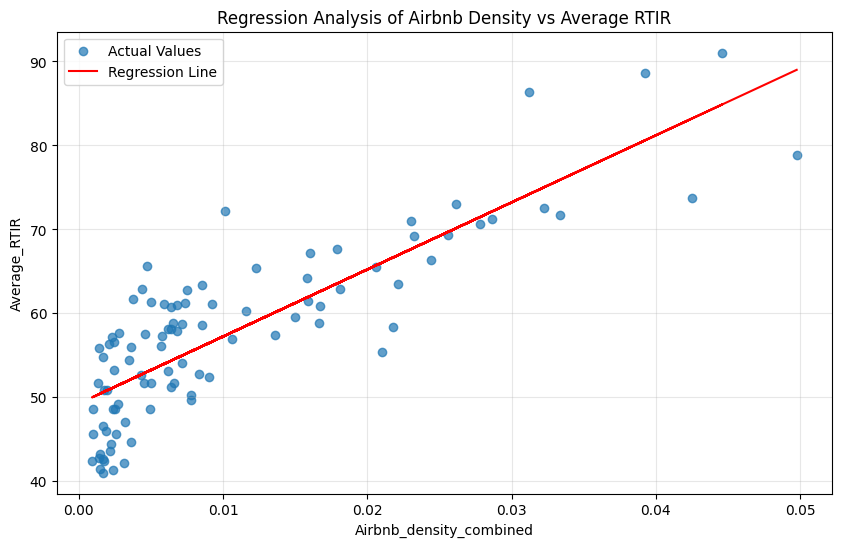

In [11]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

file_path = "final_combined_density_RTIR.csv"
data = pd.read_csv(file_path)

# Exclude rows where the 'Borough' column has the value 'City of London'
filtered_data = data[data['Borough'] != 'City of London']

# Define the independent variable (X) and dependent variable (y)
X = filtered_data['Airbnb_density_combined']  
y = filtered_data['Average_RTIR']            

# Add a constant term to the regression model
X_with_const = sm.add_constant(X)

# Perform regression analysis
model = sm.OLS(y, X_with_const)
results = model.fit()

# Print regression analysis results
print(results.summary())

plt.figure(figsize=(10, 6))
plt.scatter(X, y, label="Actual Values", alpha=0.7)
plt.plot(X, results.predict(X_with_const), color="red", label="Regression Line")
plt.title("Regression Analysis of Airbnb Density vs Average RTIR")
plt.xlabel("Airbnb_density_combined")
plt.ylabel("Average_RTIR")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [12]:
import pandas as pd

input_file_path = "ONS_Rental_Data/rent_income_ratios_corrected.csv"  
final_density_file = "final_combined_density_RTIR.csv"  
output_file = "predict.csv"  

# Load the ONS_Rental_Data file
try:
    df_rental = pd.read_csv(input_file_path)
    print("ONS Rental Data file loaded successfully.")
except FileNotFoundError:
    print(f"Error: File {input_file_path} not found.")
    exit()

# Load the final_combined_density_RTIR file
try:
    df_density = pd.read_csv(final_density_file)
    print("Final density file loaded successfully.")
except FileNotFoundError:
    print(f"Error: File {final_density_file} not found.")
    exit()

try:
    df_rental_filtered = df_rental.iloc[:, [0, 1, 4]]  
    df_rental_filtered.columns = ['Borough', 'Year', 'Median income (£)'] 
    df_rental_filtered = df_rental_filtered[df_rental_filtered['Year'] == 2024]  
    df_rental_filtered = df_rental_filtered.drop_duplicates()  
except IndexError:
    print("Error: ONS Rental Data file does not have enough columns (less than 5).")
    exit()

df_density_filtered = df_density[df_density["Year"] == 2024][["Borough", "Airbnb_density_combined"]]

# Merge the two datasets on the Borough column
df_merged = pd.merge(df_rental_filtered, df_density_filtered, on="Borough", how="left")

# Save the final result as predict.csv
df_merged.to_csv(output_file, index=False)

print(f"Predict file saved to {output_file}.")
print("Preview of the final data:")
print(df_merged.head())

ONS Rental Data file loaded successfully.
Final density file loaded successfully.
Predict file saved to predict.csv.
Preview of the final data:
                Borough  Year  Median income (£)  Airbnb_density_combined
0  Barking and Dagenham  2024            29812.0                 0.002808
1                Barnet  2024            36163.0                 0.006802
2                Bexley  2024            38573.0                 0.001690
3                 Brent  2024            33386.0                 0.010133
4               Bromley  2024            40354.0                 0.002574


In [13]:
import pandas as pd
import statsmodels.api as sm

data_file = "final_combined_density_RTIR.csv"
predict_file = "predict.csv"  

# Load the regression analysis data
data = pd.read_csv(data_file)

filtered_data = data[data['Borough'] != 'City of London']

# Define independent variable (X) and dependent variable (y)
X = filtered_data['Airbnb_density_combined']
y = filtered_data['Average_RTIR']

# Add a constant term to the regression model
X_with_const = sm.add_constant(X)

model = sm.OLS(y, X_with_const)
results = model.fit()

print(results.summary())

predict_data = pd.read_csv(predict_file)

# Use the model to predict values for 'Airbnb_density_combined'
predict_X = predict_data['Airbnb_density_combined']
predict_X_with_const = sm.add_constant(predict_X)  # 添加常数项
predict_data['Average_RTIR_predict'] = results.predict(predict_X_with_const)

# Generate a new column by multiplying the 'Median income (£)' column with the predicted RTIR values
predict_data['Long_term_rent_predict'] = predict_data['Median income (£)'] * predict_data['Average_RTIR_predict'] * 0.01

output_file = "predict_outcome.csv"
predict_data.to_csv(output_file, index=False)
print(f"The processed results have been saved to {output_file}")

                            OLS Regression Results                            
Dep. Variable:           Average_RTIR   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     215.3
Date:                Sat, 14 Dec 2024   Prob (F-statistic):           4.81e-26
Time:                        15:25:54   Log-Likelihood:                -303.86
No. Observations:                  96   AIC:                             611.7
Df Residuals:                      94   BIC:                             616.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

# Analysis of Long Term Rent Predictions by Borough

# Key Insights
## **Overall Distribution**:
### The predicted long-term rents vary significantly across London boroughs.
### Boroughs such as **Kensington and Chelsea** and **City of London** have the highest predicted rents, exceeding £50,000.

## **High Rent Areas**:
### **City of London**: The highest predicted rent, likely due to its central location and high short-term rental activity.
### **Kensington and Chelsea**: Known for its affluent neighborhoods, also shows very high predicted rents.

## **Low Rent Areas**:
### Boroughs like **Barking and Dagenham** and **Havering** have much lower predicted rents, around £10,000–£15,000, making them more affordable for long-term tenants.

## **Relationship to Airbnb Density**:
## High-rent boroughs correspond to areas with higher Airbnb density, supporting the hypothesis that short-term rentals reduce affordability for long-term renters.

## Implications
### There is a stark disparity in long-term rental affordability across London boroughs.
### Central and high-tourism areas are significantly less affordable, potentially due to the influence of short-term rental platforms like Airbnb.
### Policymakers may need to consider regulations to limit Airbnb density in high-rent areas to address affordability issues.


File loaded successfully.


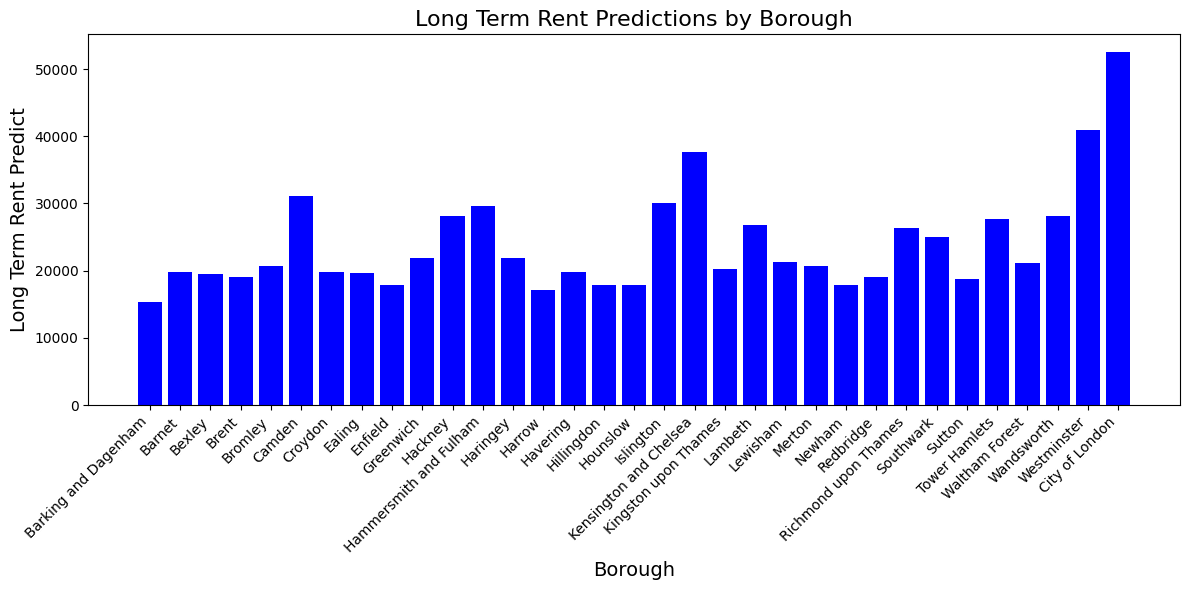

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

input_file_path = "predict_outcome.csv"

try:
    df = pd.read_csv(input_file_path)
    print("File loaded successfully.")
except FileNotFoundError:
    print(f"Error: File {input_file_path} not found.")
    exit()

required_columns = ['Borough', 'Long_term_rent_predict']
if not all(col in df.columns for col in required_columns):
    print("Error: Required columns are missing in the file.")
    exit()

df_filtered = df[required_columns]

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(df_filtered['Borough'], df_filtered['Long_term_rent_predict'], color='blue')

# Set the chart title and axis labels
plt.title('Long Term Rent Predictions by Borough', fontsize=16)
plt.xlabel('Borough', fontsize=14)
plt.ylabel('Long Term Rent Predict', fontsize=14)

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=45, ha='right')

plt.tight_layout() 
plt.show()


In [15]:

# Import necessary libraries
import os
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
from time import time as tt
import urllib

# Function to download or verify the GPKG file exists
def download_gpkg(url, download_folder, gpkg_filename):
    # Ensure the folder exists
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)
        print(f"Created directory: {download_folder}")
    
    # Path to the GeoPackage file
    poi_gpkg_path = os.path.join(download_folder, gpkg_filename)
    
    """# Check if the GPKG already exists
    if os.path.exists(poi_gpkg_path):
        print(f"GeoPackage already exists at {poi_gpkg_path}")
        return poi_gpkg_path"""

    # Download the GeoPackage file
    print(f"Downloading GeoPackage from {url}...")
    urllib.request.urlretrieve(poi_gpkg_url, os.path.join(download_folder, gpkg_filename))

    return poi_gpkg_path

# Define variables for downloading and loading the GeoPackage
poi_gpkg_url = "https://www.dropbox.com/scl/fi/lxpr6d4g22sr9tqdvpwan/poi_uk.gpkg?rlkey=64qkk7oou2kdlk4xgfi3kmcpn&st=0pxso0k6&dl=1"  # Adjusted URL for direct download
download_folder = os.path.join("Double-Win-Files", "POI-Data")
gpkg_filename = "poi-data.gpkg"

# Download and verify the GeoPackage
poi_gpkg_path = download_gpkg(poi_gpkg_url, download_folder, gpkg_filename)

# Load the GeoPackage data into a GeoDataFrame
poi_gdf = gpd.read_file(poi_gpkg_path)  # Use the full path to the downloaded GeoPackage

# Filter the rows where 'main_category' is "landmark_and_historical_building"
processed_poi_gdf = poi_gdf[poi_gdf['main_category'] == 'landmark_and_historical_building']


Created directory: Double-Win-Files/POI-Data


In [16]:
import re

def filter_poi_by_boroughs(processed_poi_gdf, shapefile_gdf):
    """Filters POI data by checking if the points are within the London Boroughs."""

    # Reproject the POI GeoDataFrame to match the shapefile's CRS (EPSG:27700)
    processed_poi_gdf = processed_poi_gdf.to_crs(epsg=27700)

    # Add Borough column by checking within which borough the point is located
    borough_names = []

    for _, row in processed_poi_gdf.iterrows():
        borough_name = shapefile_gdf[shapefile_gdf.geometry.contains(row['geometry'])]['NAME'].values
        borough_names.append(borough_name[0] if borough_name.size > 0 else 'Unknown')

    processed_poi_gdf['Borough'] = borough_names

    # Remove 'London Boro' using regex
    processed_poi_gdf['Borough'] = processed_poi_gdf['Borough'].apply(lambda x: re.sub(r'\s*London\s*Boro\s*', '', x, flags=re.IGNORECASE))

    # Replace specific borough names
    processed_poi_gdf['Borough'] = processed_poi_gdf['Borough'].replace({
        'City and County of the City of London': 'City of London',
        'City of Westminster': 'Westminster'
    })

    # Drop all columns except the first 4 columns
    processed_poi_gdf = processed_poi_gdf.iloc[:, :4]

    return processed_poi_gdf

# Filter processed_poi_gdf by checking if the points are within London Boroughs
processed_poi_gdf_boroughs = filter_poi_by_boroughs(processed_poi_gdf, lbo_gdf)


In [17]:
import re
import geopandas as gpd

def filter_poi_by_boroughs(processed_poi_gdf, shapefile_gdf, debug=False):
    """
    Filters POI data by checking if the points are within the London Boroughs 
    and adds a 'Borough' column with the borough name.
    """
    # Ensure the processed_poi_gdf is a fGeoDataFrame with valid geometry
    if not isinstance(processed_poi_gdf, gpd.GeoDataFrame):
        raise ValueError("processed_poi_gdf must be a GeoDataFrame.")
    if 'geometry' not in processed_poi_gdf.columns:
        raise ValueError("processed_poi_gdf must have a 'geometry' column.")
    
    # Ensure the CRS of both GeoDataFrames match
    if processed_poi_gdf.crs != shapefile_gdf.crs:
        if debug:
            print(f"CRS mismatch detected. Reprojecting processed_poi_gdf to match shapefile_gdf CRS: {shapefile_gdf.crs}")
        processed_poi_gdf = processed_poi_gdf.to_crs(shapefile_gdf.crs)
    
    # Ensure the shapefile_gdf has a 'NAME' column for borough names
    if 'NAME' not in shapefile_gdf.columns:
        raise ValueError("shapefile_gdf must have a 'NAME' column for borough names.")
    
    # Filter shapefile_gdf to only include London Boroughs if not already filtered
    if 'LBO' not in shapefile_gdf['AREA_CODE'].unique():
        shapefile_gdf = shapefile_gdf[shapefile_gdf['AREA_CODE'] == 'LBO']
    
    # Check and repair invalid geometries
    if not processed_poi_gdf.is_valid.all():
        if debug:
            print("Repairing invalid geometries in processed_poi_gdf.")
        processed_poi_gdf = processed_poi_gdf.buffer(0)
    
    # Perform a spatial join to add borough names
    joined_gdf = gpd.sjoin(processed_poi_gdf, shapefile_gdf[['NAME', 'geometry']], how='inner', predicate='within')
    
    # Clean up the 'NAME' column
    joined_gdf.rename(columns={'NAME': 'Borough'}, inplace=True)
    joined_gdf['Borough'] = joined_gdf['Borough'].fillna('Unknown')
    
    # Ensure all values in the 'Borough' column are strings before applying regex
    joined_gdf['Borough'] = joined_gdf['Borough'].astype(str).map(
        lambda x: re.sub(r'\s*London\s*Boro\s*', '', x, flags=re.IGNORECASE)
    )

    # Replace specific borough names for consistency
    joined_gdf['Borough'] = joined_gdf['Borough'].replace({
        'City and County of the City of London': 'City of London',
        'City of Westminster': 'Westminster'
    })
    
    return joined_gdf

processed_poi_gdf_boroughs = filter_poi_by_boroughs(processed_poi_gdf, lbo_gdf, debug=True)

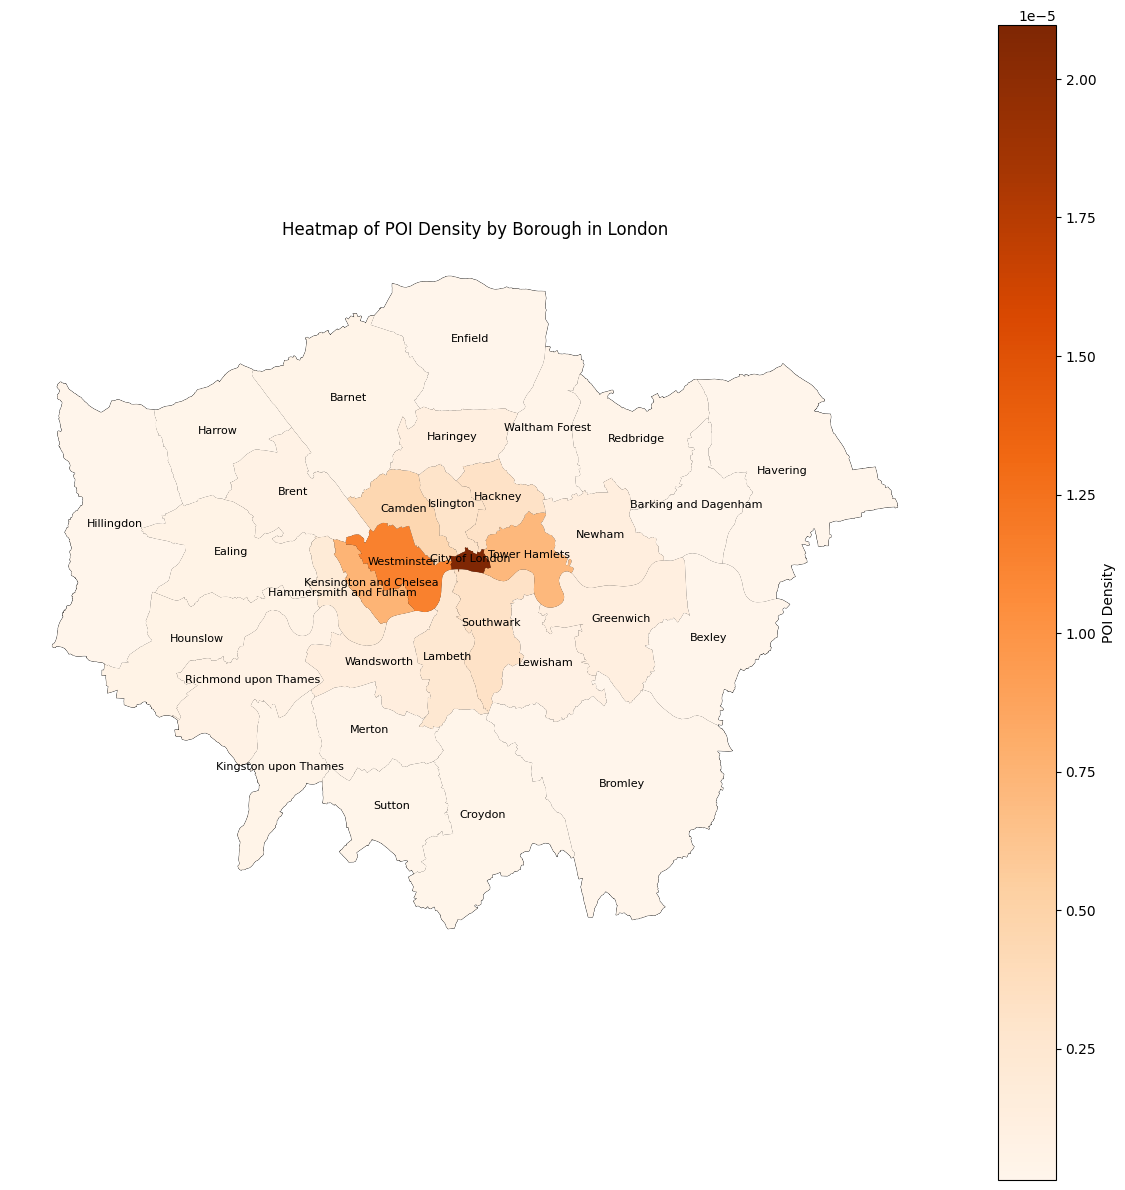

In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt
import re

def update_shapefile(lbo_gdf):
    # Create a copy to avoid modifying a slice of the original GeoDataFrame
    lbo_gdf = lbo_gdf.copy()

    # Remove 'London Boro' using regex
    lbo_gdf['NAME'] = lbo_gdf['NAME'].apply(lambda x: re.sub(r'\s*London\s*Boro\s*', '', x, flags=re.IGNORECASE))

    # Replace specific borough names
    lbo_gdf['NAME'] = lbo_gdf['NAME'].replace({
        'City and County of the City of London': 'City of London',
        'City of Westminster': 'Westminster'
    })

    return lbo_gdf

def create_poi_density_heatmap(processed_poi_gdf_boroughs, lbo_gdf):
    """
    Creates a heatmap showing the density of POI in each borough.
    """
    # Ensure processed_poi_gdf_boroughs has an active geometry column
    if 'geometry_poi' in processed_poi_gdf_boroughs.columns:
        processed_poi_gdf_boroughs = processed_poi_gdf_boroughs.set_geometry('geometry_poi')
    elif 'geometry' in processed_poi_gdf_boroughs.columns:
        processed_poi_gdf_boroughs = processed_poi_gdf_boroughs.set_geometry('geometry')
    else:
        raise ValueError("processed_poi_gdf_boroughs must have a valid geometry column.")
    
    # Ensure lbo_gdf has an active geometry column
    if 'geometry' not in lbo_gdf.columns:
        raise ValueError("lbo_gdf does not have a 'geometry' column.")

    # Rename or drop conflicting column 'index_right'
    processed_poi_gdf_boroughs = processed_poi_gdf_boroughs.drop(columns=['index_right'], errors='ignore')
    lbo_gdf = lbo_gdf.drop(columns=['index_right'], errors='ignore')

    # Align CRS of both GeoDataFrames
    if processed_poi_gdf_boroughs.crs != lbo_gdf.crs:
        processed_poi_gdf_boroughs = processed_poi_gdf_boroughs.to_crs(lbo_gdf.crs)

    # Perform the spatial join with suffixes to avoid column name conflicts
    poi_boroughs = gpd.sjoin(
        processed_poi_gdf_boroughs, 
        lbo_gdf[['NAME', 'geometry']],
        how="inner",
        predicate="within",
        lsuffix="left",
        rsuffix="right"
    )

    # Group by the borough name column from lbo_gdf
    poi_counts = poi_boroughs.groupby('NAME').size().reset_index(name='poi_count')

    # Calculate the area of each borough (in square meters)
    if lbo_gdf.crs != "EPSG:27700":  # Ensure CRS in meters
        lbo_gdf = lbo_gdf.to_crs("EPSG:27700")
    lbo_gdf['area_m2'] = lbo_gdf.geometry.area

    # Merge the POI counts with the borough lbo_gdf
    boroughs_gdf = lbo_gdf.set_index('NAME').join(
        poi_counts.set_index('NAME'), how='left'
    )
    boroughs_gdf['poi_count'] = boroughs_gdf['poi_count'].fillna(0)

    # Calculate the density of POI (number of POI / area of the borough)
    boroughs_gdf['poi_density'] = (boroughs_gdf['poi_count'] / boroughs_gdf['area_m2'])

    # Plot the borough boundaries and POI density
    fig, ax = plt.subplots(figsize=(15, 15))
    base = boroughs_gdf.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5)
    boroughs_gdf.plot(
        column='poi_density',
        ax=ax,
        legend=True,
        cmap='Oranges',
        legend_kwds={'label': 'POI Density'}
    )

    # Add borough names
    for x, y, label in zip(
        boroughs_gdf.geometry.centroid.x, 
        boroughs_gdf.geometry.centroid.y, 
        boroughs_gdf.index
    ):
        ax.text(x, y, label, fontsize=8, ha='center', color='black')

    # Set plot title and labels
    ax.set_title("Heatmap of POI Density by Borough in London")
    ax.set_axis_off()

    plt.show()

    return boroughs_gdf

lbo_gdf = update_shapefile(lbo_gdf)
# Create the heatmap
boroughs_gdf = create_poi_density_heatmap(processed_poi_gdf_boroughs, lbo_gdf)

In [19]:
import os
import pandas as pd
from tabulate import tabulate

boroughs_gdf.reset_index(inplace=True)

# Ensure 'NAME' is renamed to 'Borough' in boroughs_gdf
boroughs_gdf = boroughs_gdf.rename(columns={'NAME': 'Borough'})

# Merge merged_data with boroughs_gdf based on the 'Borough' column
#merged_data = merged_data[['Borough', 'Airbnb_density_combined', 'Year', 'Average_RTIR']]

# Perform the merge
merged_data_poi = pd.merge(merged_data, boroughs_gdf[['Borough', 'poi_density']], on='Borough', how='left')

# Ensure 'poi_density' column exists (if not, create or debug further)
if 'poi_density' not in merged_data_poi.columns:
    print("poi_density column not found. Check if it was merged correctly.")
else:
    # Fill any missing values with 0 for the 'poi_density' column
    merged_data_poi['poi_density'] = merged_data_poi['poi_density'].fillna(0)

    # Save the updated DataFrame with 'poi_density' to CSV
    output_file_path = os.path.join(os.getcwd(), "final_merged_data_with_poi.csv")
    merged_data_poi.to_csv(output_file_path, index=False)

    print(f"Data has been saved to: {output_file_path}")


Data has been saved to: /Users/pjannand/Documents/CASA/FSDS/CASA0013/double-win/Final-code/final_merged_data_with_poi.csv


In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Dissolve all boroughs into a single geometry
london_combined = lbo_gdf.dissolve()

# Calculate the centroid of the dissolved geometry
london_centroid = london_combined.geometry.centroid.iloc[0]

# Extract X and Y coordinates
eastings = london_centroid.x  # X coordinate (easting)
northings = london_centroid.y  # Y coordinate (northing)

print(f"Geographical Center of London: Easting = {eastings}, Northing = {northings}")


Geographical Center of London: Easting = 531330.8033141145, Northing = 179645.99535961243


In [21]:
import geopandas as gpd
import pandas as pd

# Assuming lbo_gdf and merged_data_poi are already loaded
# Ensure lbo_gdf is in the correct CRS (EPSG:27700 for British National Grid)
if lbo_gdf.crs != "EPSG:27700":
    lbo_gdf = lbo_gdf.to_crs("EPSG:27700")

# Step 1: Calculate the overall London centroid
london_centroid = lbo_gdf.geometry.union_all().centroid  # Use union_all() instead of unary_union

# Step 2: Calculate each borough's centroid
lbo_gdf['centroid'] = lbo_gdf.geometry.centroid

# Step 3: Calculate distance from each borough centroid to the London centroid
lbo_gdf['distance_from_centre'] = lbo_gdf['centroid'].apply(lambda point: point.distance(london_centroid))

# Step 4: Create a dictionary to map borough names to distances
distance_dict = dict(zip(lbo_gdf['NAME'], lbo_gdf['distance_from_centre']))

# Step 5: Add the 'distance_from_centre' column to merged_data_poi
# Match 'Borough' in merged_data_poi with 'NAME' in lbo_gdf and assign distances
merged_data_poi['distance_from_centre'] = merged_data_poi['Borough'].map(distance_dict)

# Display the updated DataFrame
print("merged_data_poi:") 
print(tabulate(merged_data_poi.head(), headers="keys", tablefmt="pretty"))

merged_data_poi:
+---+----------------------+-------------------------+------+--------------------+------------------------+----------------------+
|   |       Borough        | Airbnb_density_combined | Year |    Average_RTIR    |      poi_density       | distance_from_centre |
+---+----------------------+-------------------------+------+--------------------+------------------------+----------------------+
| 0 | Barking and Dagenham |   0.0016888001842327    | 2022 | 54.80211837114435  | 2.117419468523895e-07  |  17508.983662761944  |
| 1 |        Barnet        |   0.0035852719305456    | 2022 | 55.99334586118727  | 4.033790008058738e-07  |  14624.330728461875  |
| 2 |        Bexley        |   0.0009197976445182    | 2022 | 42.33020198685435  | 1.8659754816947132e-07 |  18027.51074090639   |
| 3 |        Brent         |   0.0063529501274394    | 2022 | 58.063151041666664 | 7.169890332084462e-07  |  12752.005673607739  |
| 4 |       Bromley        |   0.0014908264945183    | 2022 | 43.2

In [22]:
# Add a column for the number of properties each host_id has
combined_df['host_property_count'] = combined_df.groupby('host_id')['id'].transform('count')

# Rename 'Year' to 'scrape_year' in merged_data_poi for consistency
combined_df = combined_df.rename(columns={'scrape_year': 'Year'})


# Print the updated DataFrame to verify the new column
print("First few rows of combined_df with host_property_count:")
print(combined_df.head())

# Save the updated DataFrame back to the output file
output_combined_file_updated = os.path.join(output_folder, "Airbnb_combined_dataset_with_host_property_count.csv")
combined_df.to_csv(output_combined_file_updated, index=False)


First few rows of combined_df with host_property_count:
       id  host_id   latitude  longitude last_review  availability_365  \
1  117203   255103  51.501550  -0.233002  09/06/2024                33   
2  127652   134938  51.559528  -0.144319  09/07/2024               134   
3  131444   646165  51.491476  -0.111514  15/06/2024                 6   
4  137581   471088  51.510990  -0.078620  13/08/2024               160   
5  137907    67564  51.521970  -0.140350  15/06/2024                25   

         room_type  Year                 Borough  is_long_term  \
1  Entire home/apt  2024  Hammersmith and Fulham         False   
2  Entire home/apt  2024                  Camden          True   
3  Entire home/apt  2024                 Lambeth         False   
4  Entire home/apt  2024          City of London          True   
5  Entire home/apt  2024                  Camden         False   

   host_property_count  
1                    3  
2                    2  
3                    6  
4 

In [23]:
# Filter Airbnb listings for entire properties
df_whole_properties = combined_df[combined_df['room_type'] == 'Entire home/apt']

# Count total listings per borough and year
total_whole_properties = df_whole_properties.groupby(['Borough', 'Year']).size().reset_index(name='Total_Whole_Properties')

# Count multiple-host listings per borough and year
multiple_hosts_properties = df_whole_properties[df_whole_properties['host_property_count'] >= 10]
professional_listings = multiple_hosts_properties.groupby(['Borough', 'Year']).size().reset_index(name='Professional_Listings')

# Merge both counts on Borough and Year
df_professional_ratio = pd.merge(total_whole_properties, professional_listings, on=['Borough', 'Year'], how='left')
df_professional_ratio['Professional_Listings'] = df_professional_ratio['Professional_Listings'].fillna(0)

# Calculate proportion
df_professional_ratio['Proportion_professional_listings'] = (
    df_professional_ratio['Professional_Listings'] / df_professional_ratio['Total_Whole_Properties']
)


# Merge merged_data_poi with df_professional_ratio to include 'Proportion_Professional_Listings'
merged_final_data = pd.merge(
    merged_data_poi,
    df_professional_ratio[['Borough', 'Year', 'Proportion_professional_listings']],
    on=['Borough', 'Year'],
    how='left'
)

# Calculate the median availability_365 per borough and year from combined_df
median_availability = combined_df.groupby(['Borough', 'Year'])['availability_365'].median().reset_index()
median_availability.rename(columns={'availability_365': 'Median_availability_365'}, inplace=True)

# Merge the median availability data with merged_final_data on both Borough and Year
merged_final_data = pd.merge(merged_final_data, median_availability, on=['Borough', 'Year'], how='left')

merged_final_data = merged_final_data[merged_final_data['Borough'] != 'City of London']

# Print the updated merged_data_poi DataFrame
merged_final_data

,Borough,Airbnb_density_combined,Year,Average_RTIR,poi_density,distance_from_centre,Proportion_professional_listings,Median_availability_365
0,Barking and Dagenham,0.001689,2022,54.802118,2.117419e-07,17508.983663,0.121212,156.5
1,Barnet,0.003585,2022,55.993346,4.033790e-07,14624.330728,0.317460,93.0
2,Bexley,0.000920,2022,42.330202,1.865975e-07,18027.510741,0.250000,169.0
3,Brent,0.006353,2022,58.063151,7.169890e-07,12752.005674,0.281437,46.0
4,Bromley,0.001491,2022,43.207292,1.532037e-07,18151.360260,0.103774,44.0
...,...,...,...,...,...,...,...,...
94,Sutton,0.001901,2024,45.998490,2.508758e-07,16111.741047,0.274390,120.0
95,Tower Hamlets,0.024381,2024,66.385455,7.183605e-06,5452.186453,0.286585,69.0
96,Waltham Forest,0.007755,2024,50.299685,3.091968e-07,12376.963065,0.135514,64.0
97,Wandsworth,0.015885,2024,61.424858,1.334619e-06,7593.733545,0.226069,66.0


In [24]:
import pandas as pd
import statsmodels.api as sm

# Ensure 'Average_RTIR' is the target variable
X = merged_final_data[['Airbnb_density_combined', 'poi_density', 'distance_from_centre', 'Proportion_professional_listings', 'Median_availability_365']]
y = merged_final_data['Average_RTIR']

# Add a constant term to the predictor matrix for the intercept
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Average_RTIR   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     53.52
Date:                Sat, 14 Dec 2024   Prob (F-statistic):           1.69e-25
Time:                        15:29:24   Log-Likelihood:                -294.80
No. Observations:                  96   AIC:                             601.6
Df Residuals:                      90   BIC:                             617.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

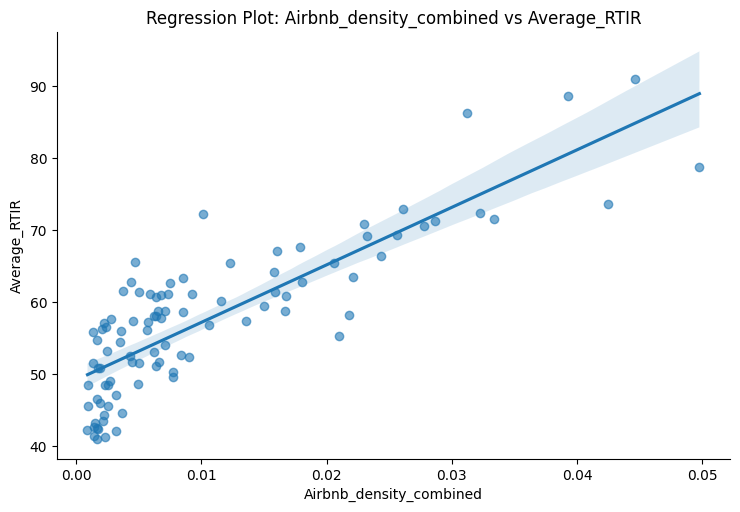

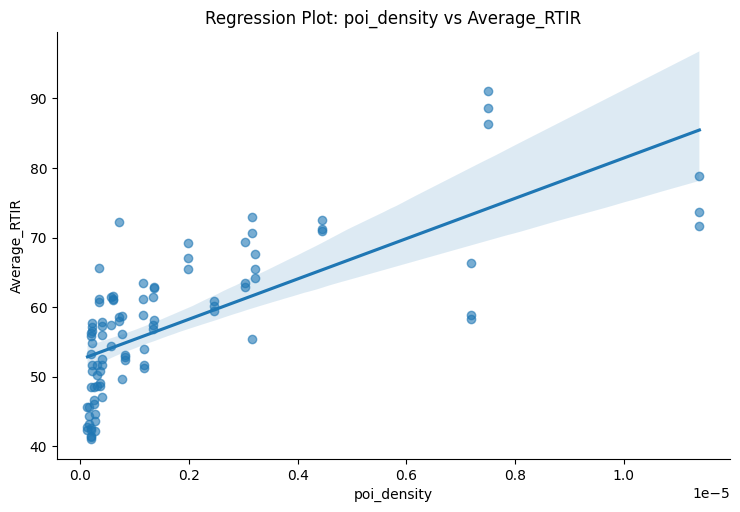

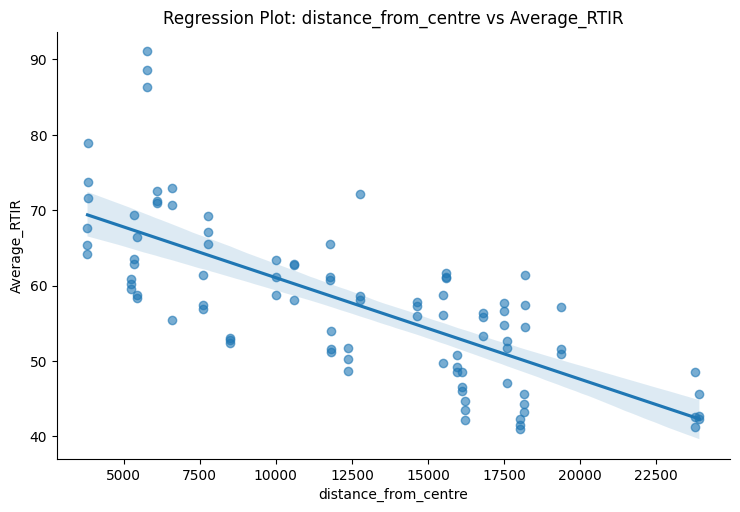

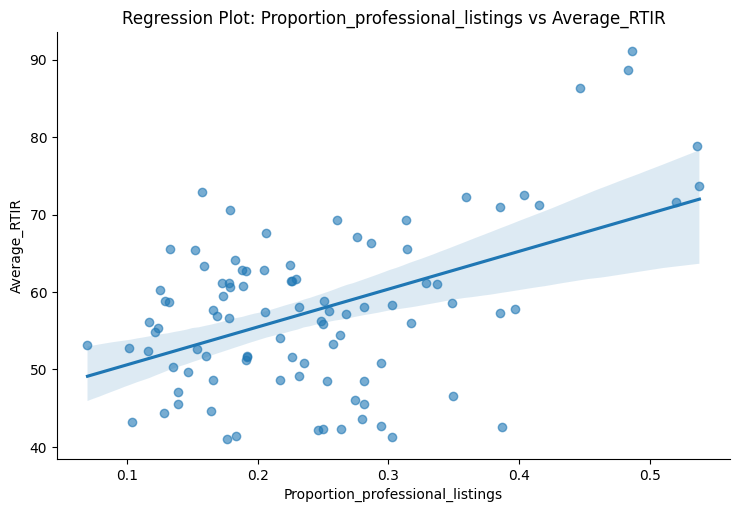

In [25]:
# Regression plots for each variable
for feature in ['Airbnb_density_combined', 'poi_density', 'distance_from_centre', 'Proportion_professional_listings']:
    sns.lmplot(x=feature, y='Average_RTIR', data=merged_final_data, aspect=1.5, scatter_kws={'alpha':0.6})
    plt.title(f'Regression Plot: {feature} vs Average_RTIR')
    plt.show()


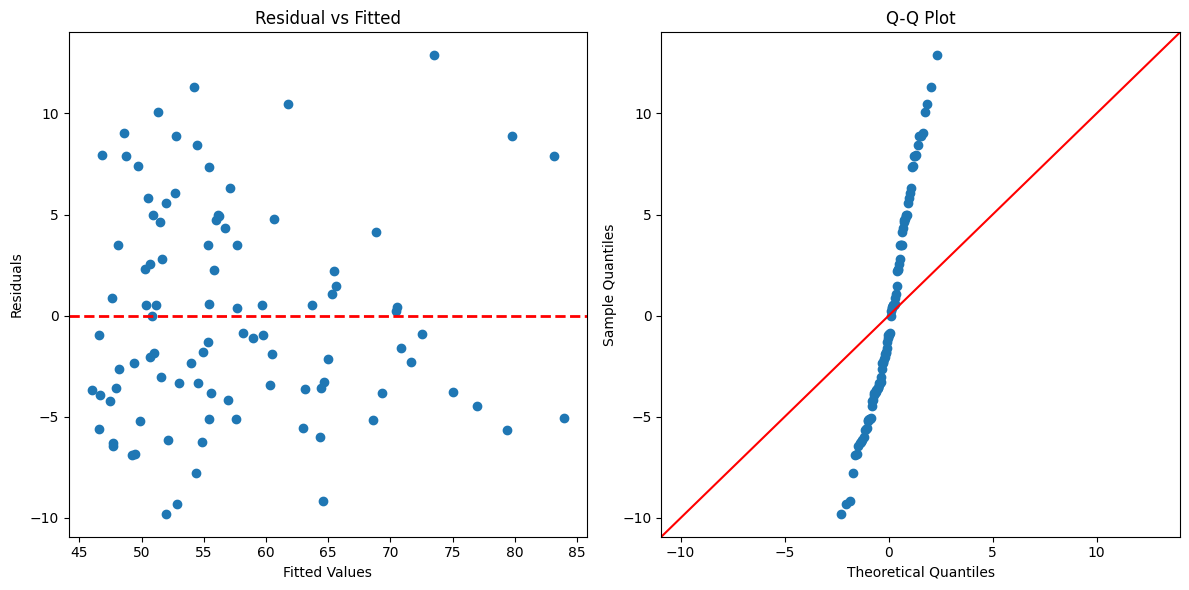

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats

# Fit the regression model
model = sm.OLS(y, X).fit()

# Get residuals and fitted values
residuals = model.resid
fitted_values = model.fittedvalues

# Residual vs Fitted plot
plt.figure(figsize=(12, 6))

# Residual vs Fitted plot
plt.subplot(1, 2, 1)
plt.scatter(fitted_values, residuals)
plt.axhline(0, color='red', linestyle='--', linewidth=2)  # Horizontal line at 0
plt.title('Residual vs Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

# Q-Q plot
plt.subplot(1, 2, 2)
sm.qqplot(residuals, line ='45', ax=plt.gca())
plt.title('Q-Q Plot')

# Show the plots
plt.tight_layout()
plt.show()


In [27]:
import plotly.express as px

# Creating the scatter plot
fig = px.scatter(
    merged_final_data, 
    x='Airbnb_density_combined', 
    y='Average_RTIR', 
    color='Borough', 
    size='Airbnb_density_combined', 
    hover_data=['Borough', 'Year', 'distance_from_centre', 'Proportion_professional_listings', 'poi_density']
)

# Rename axes and titles
fig.update_layout(
    title='Interactive Scatter Plot of Airbnb Density vs (Un)Affordability (Rent to Income Ratio)',
    xaxis_title='Airbnb Density',  # Rename x-axis
    yaxis_title='(Un)Affordability (Rent to Income Ratio)'  # Rename y-axis
)

# Rename hover data elements
fig.update_traces(
    hovertemplate=(
        'Borough: %{customdata[0]}<br>' +
        'Airbnb Density: %{x}<br>' +
        'Affordability (Rent to Income Ratio): %{y}<br>' +
        'Distance from Centre: %{customdata[2]}<br>' +
        'Year: %{customdata[1]}'
    )
)

# Show the plot
fig.show()


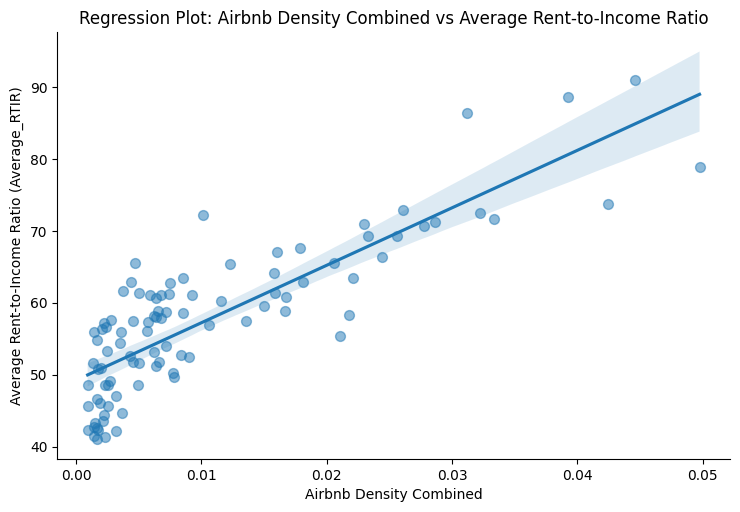

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Regression plot: Airbnb Density Combined vs Average Rent-to-Income Ratio
sns.lmplot(x='Airbnb_density_combined', y='Average_RTIR', data=merged_final_data, aspect=1.5, scatter_kws={'s': 50, 'alpha': 0.5})
plt.title('Regression Plot: Airbnb Density Combined vs Average Rent-to-Income Ratio')
plt.xlabel('Airbnb Density Combined')
plt.ylabel('Average Rent-to-Income Ratio (Average_RTIR)')
plt.show()


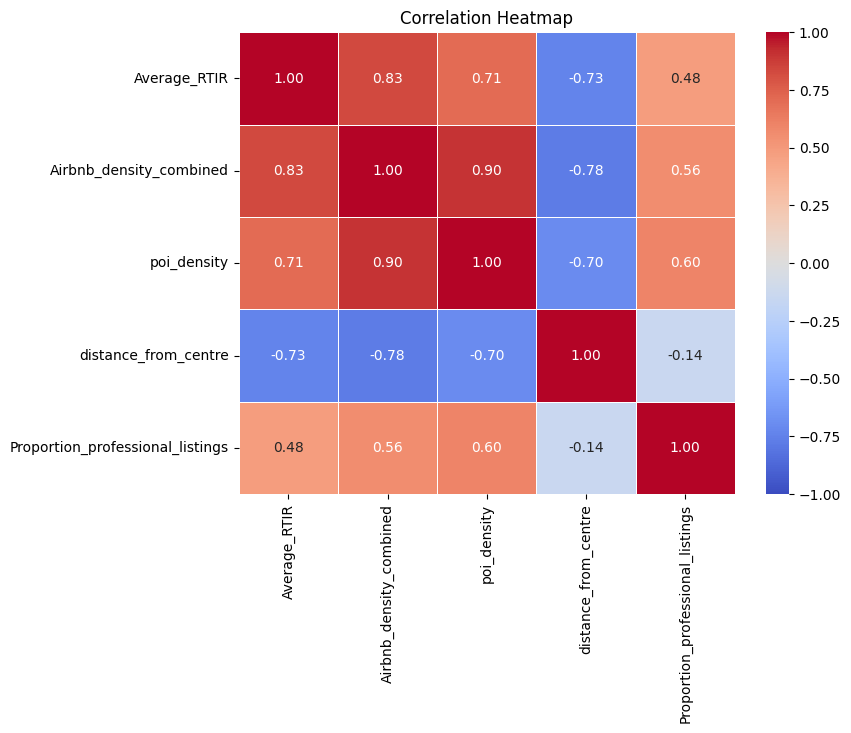

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = merged_final_data[['Average_RTIR', 'Airbnb_density_combined', 'poi_density', 'distance_from_centre', 'Proportion_professional_listings']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


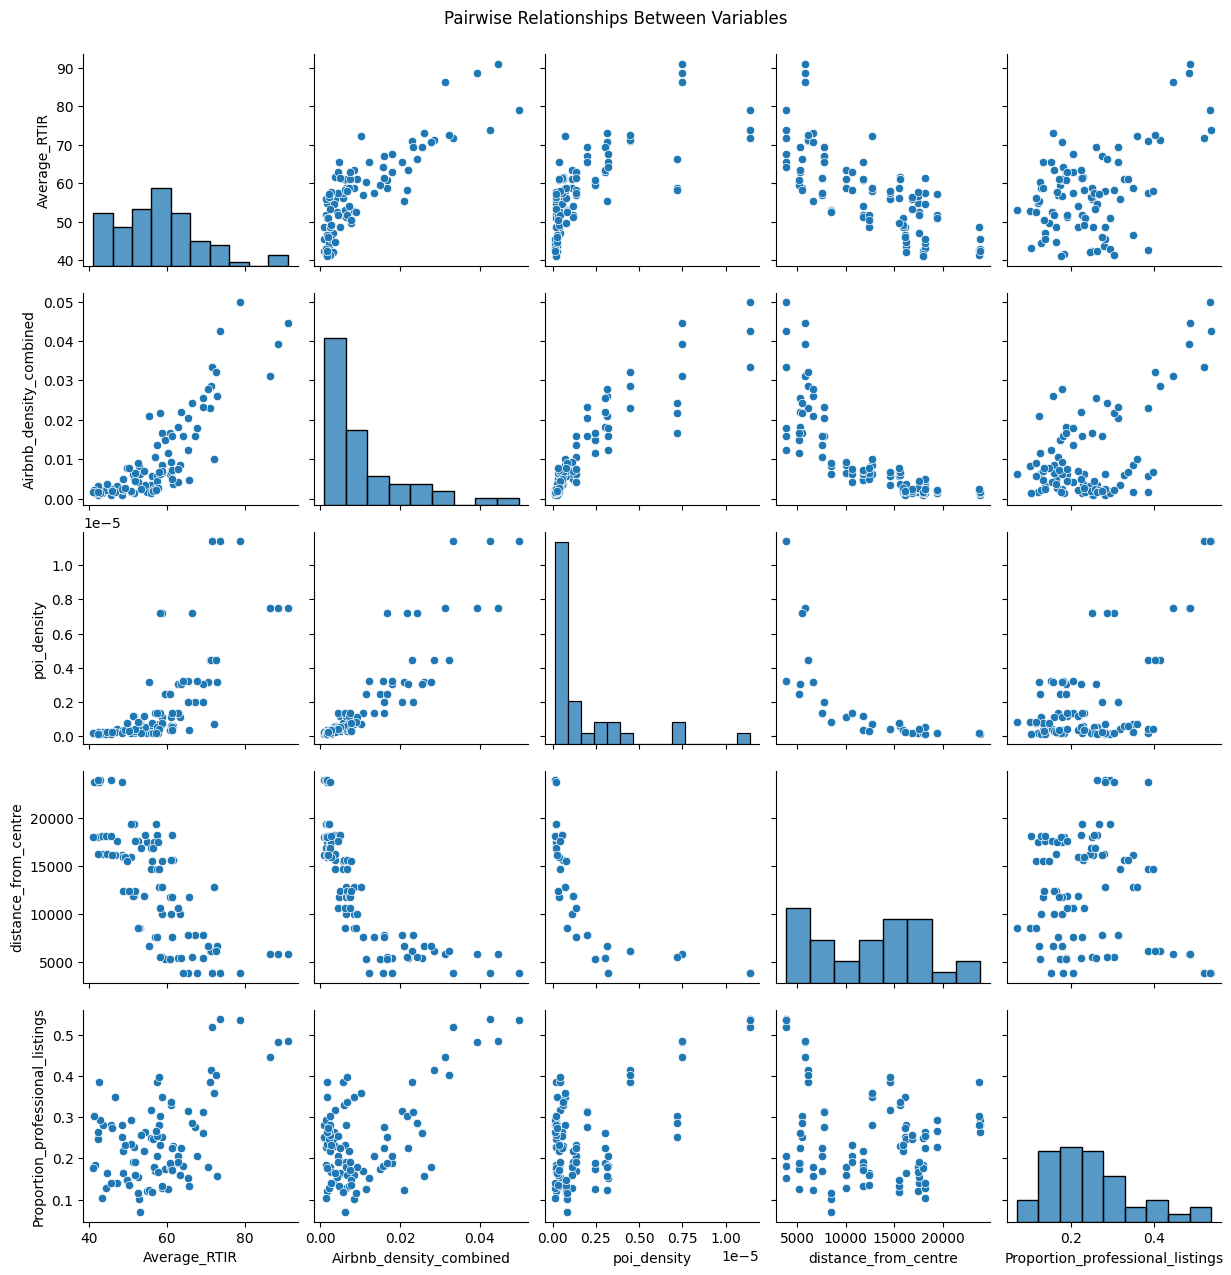

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pairplot to visualize pairwise relationships
sns.pairplot(merged_final_data[['Average_RTIR', 'Airbnb_density_combined', 'poi_density', 'distance_from_centre', 'Proportion_professional_listings']])
plt.suptitle('Pairwise Relationships Between Variables', y=1.02)
plt.show()


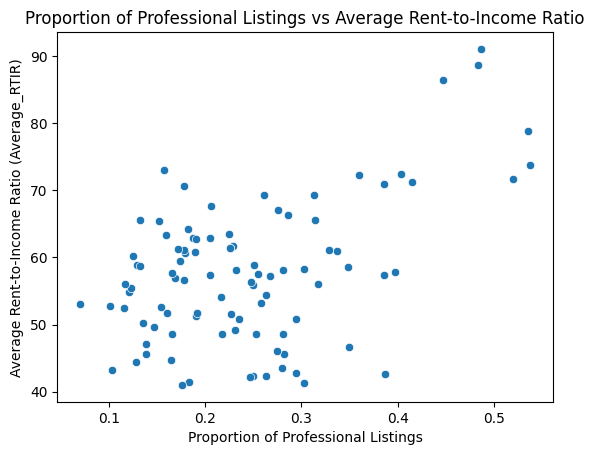

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot: Proportion of Professional Listings vs Average Rent-to-Income Ratio
sns.scatterplot(x='Proportion_professional_listings', y='Average_RTIR', data=merged_final_data)
plt.title('Proportion of Professional Listings vs Average Rent-to-Income Ratio')
plt.xlabel('Proportion of Professional Listings')
plt.ylabel('Average Rent-to-Income Ratio (Average_RTIR)')
plt.show()


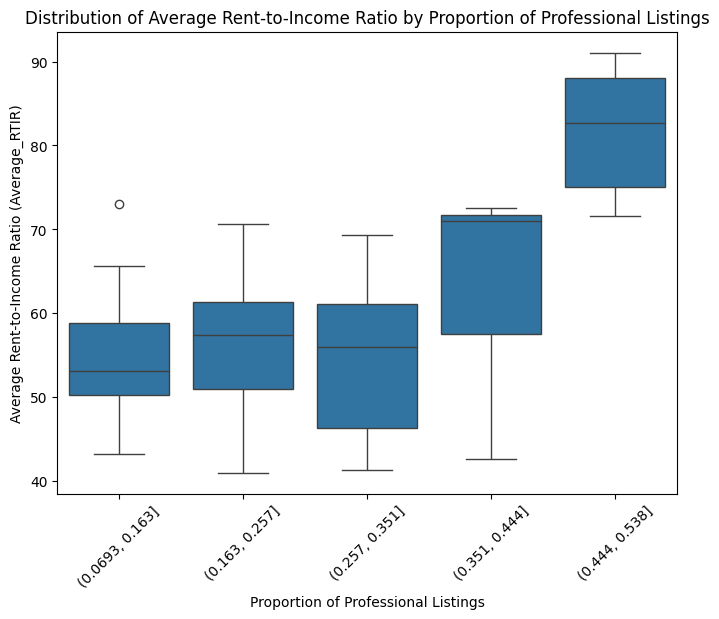

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create bins for Proportion_Professional_Listings to categorize into groups
merged_final_data['Proportion_professional_listings'] = pd.cut(merged_final_data['Proportion_professional_listings'], bins=5)

# Box plot: Distribution of Average Rent-to-Income Ratio by Proportion of Professional Listings
plt.figure(figsize=(8, 6))
sns.boxplot(x='Proportion_professional_listings', y='Average_RTIR', data=merged_final_data)
plt.title('Distribution of Average Rent-to-Income Ratio by Proportion of Professional Listings')
plt.xlabel('Proportion of Professional Listings')
plt.ylabel('Average Rent-to-Income Ratio (Average_RTIR)')
plt.xticks(rotation=45)
plt.show()


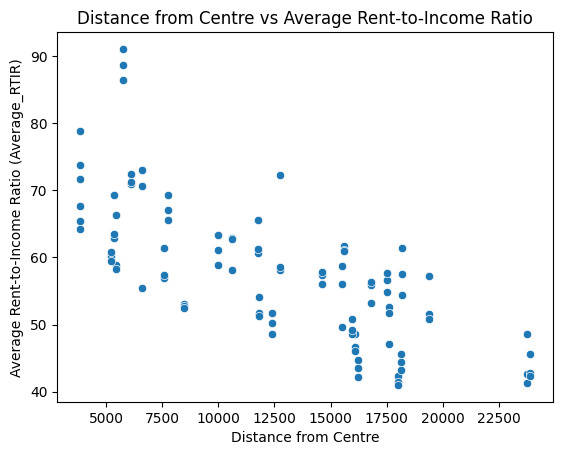

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot: Distance from Centre vs Average Rent-to-Income Ratio
sns.scatterplot(x='distance_from_centre', y='Average_RTIR', data=merged_final_data)
plt.title('Distance from Centre vs Average Rent-to-Income Ratio')
plt.xlabel('Distance from Centre')
plt.ylabel('Average Rent-to-Income Ratio (Average_RTIR)')
plt.show()


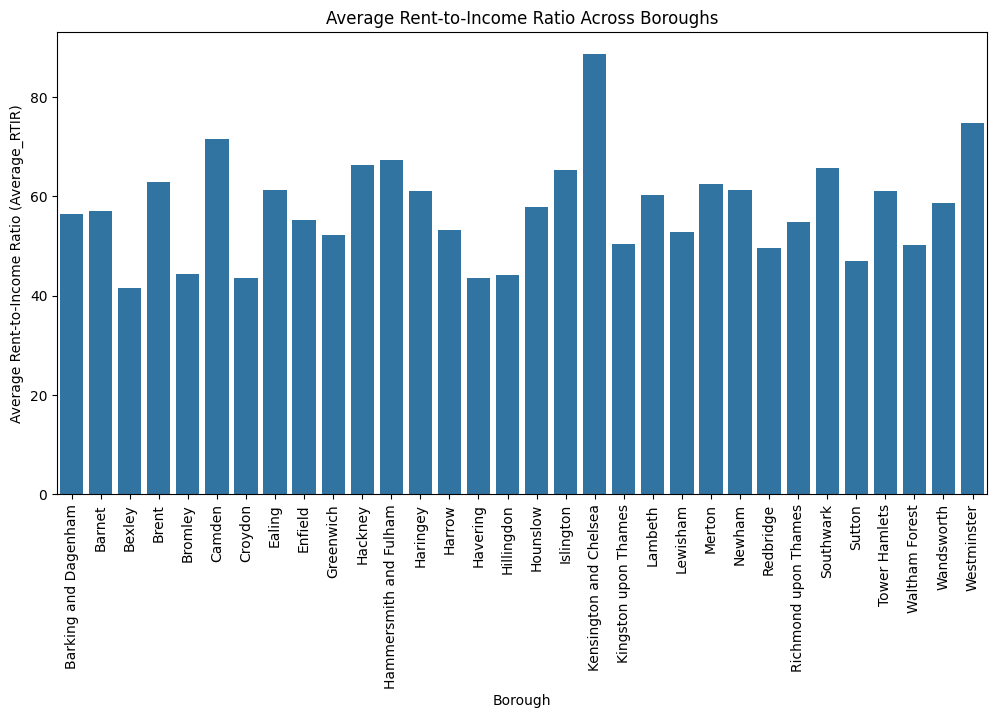

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a bar plot for Average Rent-to-Income Ratio across boroughs
plt.figure(figsize=(12, 6))
sns.barplot(x='Borough', y='Average_RTIR', data=merged_final_data, errorbar=None)
plt.title('Average Rent-to-Income Ratio Across Boroughs')
plt.xlabel('Borough')
plt.ylabel('Average Rent-to-Income Ratio (Average_RTIR)')
plt.xticks(rotation=90)
plt.show()


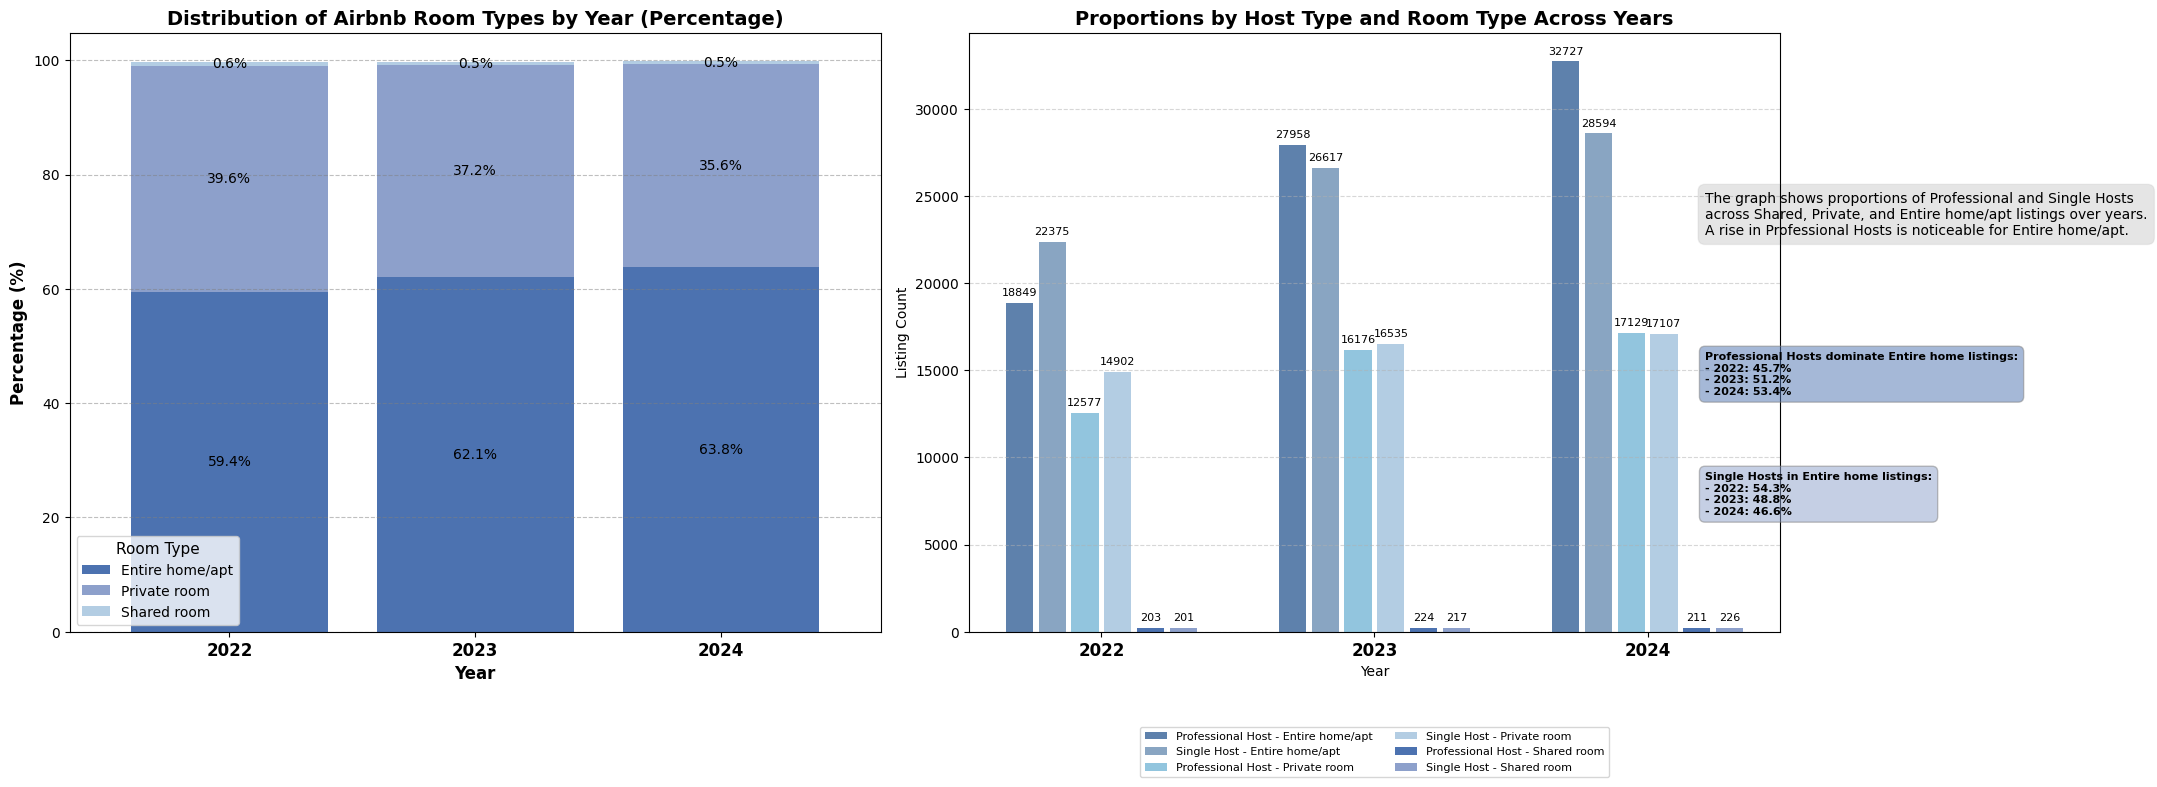

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate room type distribution percentages
def calculate_room_type_percentages(df):
    return df['room_type'].value_counts(normalize=True) * 100

# Function to calculate host proportions based on host_type and room_type
def calculate_host_proportions(df):
    grouped = df.groupby(['host_type', 'room_type']).size().reset_index(name='listings_count')
    room_type_totals = grouped.groupby('room_type')['listings_count'].sum()
    grouped['proportion'] = grouped.apply(lambda x: (x['listings_count'] / room_type_totals[x['room_type']]) * 100, axis=1)
    return grouped

# Preloaded data (replace df_2022, df_2023, df_2024 with your DataFrames)
# Example: df_2022 = <preloaded DataFrame>
assert 'df_2022' in globals() and 'df_2023' in globals() and 'df_2024' in globals(), "Please load df_2022, df_2023, and df_2024."

# Set up figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.subplots_adjust(wspace=0.4, right=0.75)

# Recalculate room type percentages
room_type_percentage_2022 = calculate_room_type_percentages(df_2022)
room_type_percentage_2023 = calculate_room_type_percentages(df_2023)
room_type_percentage_2024 = calculate_room_type_percentages(df_2024)

# Combine percentages into a DataFrame and drop 'Hotel room'
room_type_trends_percentage = pd.DataFrame({
    '2022': room_type_percentage_2022,
    '2023': room_type_percentage_2023,
    '2024': room_type_percentage_2024
}).fillna(0).drop("Hotel room", errors='ignore')

# Plot Room Type Distribution (Left)
professional_colors = ['#4C72B0', '#8DA0CB', '#B3CDE3']
room_type_trends_percentage.T.plot(kind='bar', stacked=True, ax=ax1, color=professional_colors, width=0.8)
ax1.set_title('Distribution of Airbnb Room Types by Year (Percentage)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax1.set_xticks(range(len(room_type_trends_percentage.columns)))
ax1.set_xticklabels(['2022', '2023', '2024'], rotation=0, fontsize=12, fontweight='bold')
ax1.legend(title='Room Type', fontsize=10, title_fontsize=11)
ax1.grid(axis='y', linestyle='--', alpha=0.5, color='gray')

# Add percentages above bars on left graph
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=10, color='black')

# Process Host Data for Right Graph
all_data = []
for year, df in zip(['2022', '2023', '2024'], [df_2022, df_2023, df_2024]):
    df['host_type'] = df['calculated_host_listings_count'].apply(
        lambda x: 'Single Host' if x == 1 else 'Professional Host'
    )
    proportions_df = calculate_host_proportions(df)
    proportions_df['year'] = year
    all_data.append(proportions_df)

combined_proportions = pd.concat(all_data, ignore_index=True)

# Plot Host Proportions (Right)
filtered_data = combined_proportions[combined_proportions['room_type'].isin(['Shared room', 'Private room', 'Entire home/apt'])]
room_types = sorted(['Shared room', 'Private room', 'Entire home/apt'])

pivot_data = filtered_data.pivot_table(
    index=['year', 'room_type'], columns='host_type', values='listings_count', fill_value=0
)

# Professional colors
professional_colors = {
    'Professional Host - Shared room': '#4C72B0',
    'Single Host - Shared room': '#8DA0CB',
    'Professional Host - Private room': '#92C5DE',
    'Single Host - Private room': '#B3CDE3',
    'Professional Host - Entire home/apt': '#5E81AC',
    'Single Host - Entire home/apt': '#89A5C2'
}

# Plot bars for each room type
width = 0.1
x = np.arange(len(pivot_data.index.levels[0]))

offsets = np.linspace(-0.3, 0.3, len(room_types) * 2)
for idx, room_type in enumerate(room_types):
    for host_type in ['Professional Host', 'Single Host']:
        label = f"{host_type} - {room_type}"
        values = pivot_data.xs(room_type, level=1).get(host_type, [0] * len(x))
        ax2.bar(x + offsets[idx * 2 + (0 if host_type == 'Professional Host' else 1)], values, width=width, label=label, color=professional_colors[label])

# Add values on top of bars
for idx, room_type in enumerate(room_types):
    for host_type in ['Professional Host', 'Single Host']:
        values = pivot_data.xs(room_type, level=1).get(host_type, [0] * len(x))
        for i, value in enumerate(values):
            if value > 0:
                ax2.text(i + offsets[idx * 2 + (0 if host_type == 'Professional Host' else 1)], value + 300, f"{value:.0f}", 
                         ha='center', va='bottom', fontsize=8, color='black')

ax2.set_title("Proportions by Host Type and Room Type Across Years", fontsize=14, fontweight='bold')
ax2.set_ylabel("Listing Count", fontsize=10)
ax2.set_xlabel("Year", fontsize=10)
ax2.set_xticks(x)
ax2.set_xticklabels(["2022", "2023", "2024"], rotation=0, fontsize=12, fontweight='bold')
ax2.legend(fontsize=8, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
ax2.grid(axis='y', linestyle='--', alpha=0.5)

# Add a text box outside the graph with percentages for Professional Hosts
text_box_content_pro = (
    "Professional Hosts dominate Entire home listings:\n"
    f"- 2022: {pro_host_percentages['2022']:.1f}%\n"
    f"- 2023: {pro_host_percentages['2023']:.1f}%\n"
    f"- 2024: {pro_host_percentages['2024']:.1f}%"
)
fig.text(0.95, 0.5, text_box_content_pro, fontsize=8, fontweight='bold',
         bbox=dict(facecolor='#4C72B0', edgecolor='gray', boxstyle='round,pad=0.5', alpha=0.5))

# Add a text box outside the graph with percentages for Single Hosts
text_box_content_single = (
    "Single Hosts in Entire home listings:\n"
    f"- 2022: {single_host_percentages['2022']:.1f}%\n"
    f"- 2023: {single_host_percentages['2023']:.1f}%\n"
    f"- 2024: {single_host_percentages['2024']:.1f}%"
)
fig.text(0.95, 0.35, text_box_content_single, fontsize=8, fontweight='bold',
         bbox=dict(facecolor='#8DA0CB', edgecolor='gray', boxstyle='round,pad=0.5', alpha=0.5))

# Add a text box outside the graph with percentages for Single Hosts
text_box_content_single = (
     "The graph shows proportions of Professional and Single Hosts\n"
        "across Shared, Private, and Entire home/apt listings over years.\n"
        "A rise in Professional Hosts is noticeable for Entire home/apt."
)
fig.text(0.95, 0.7, text_box_content_single, fontsize=10, fontweight='normal',
         bbox=dict(facecolor='black', edgecolor='gray', boxstyle='round,pad=0.5', alpha=0.1))

plt.tight_layout()
plt.show()


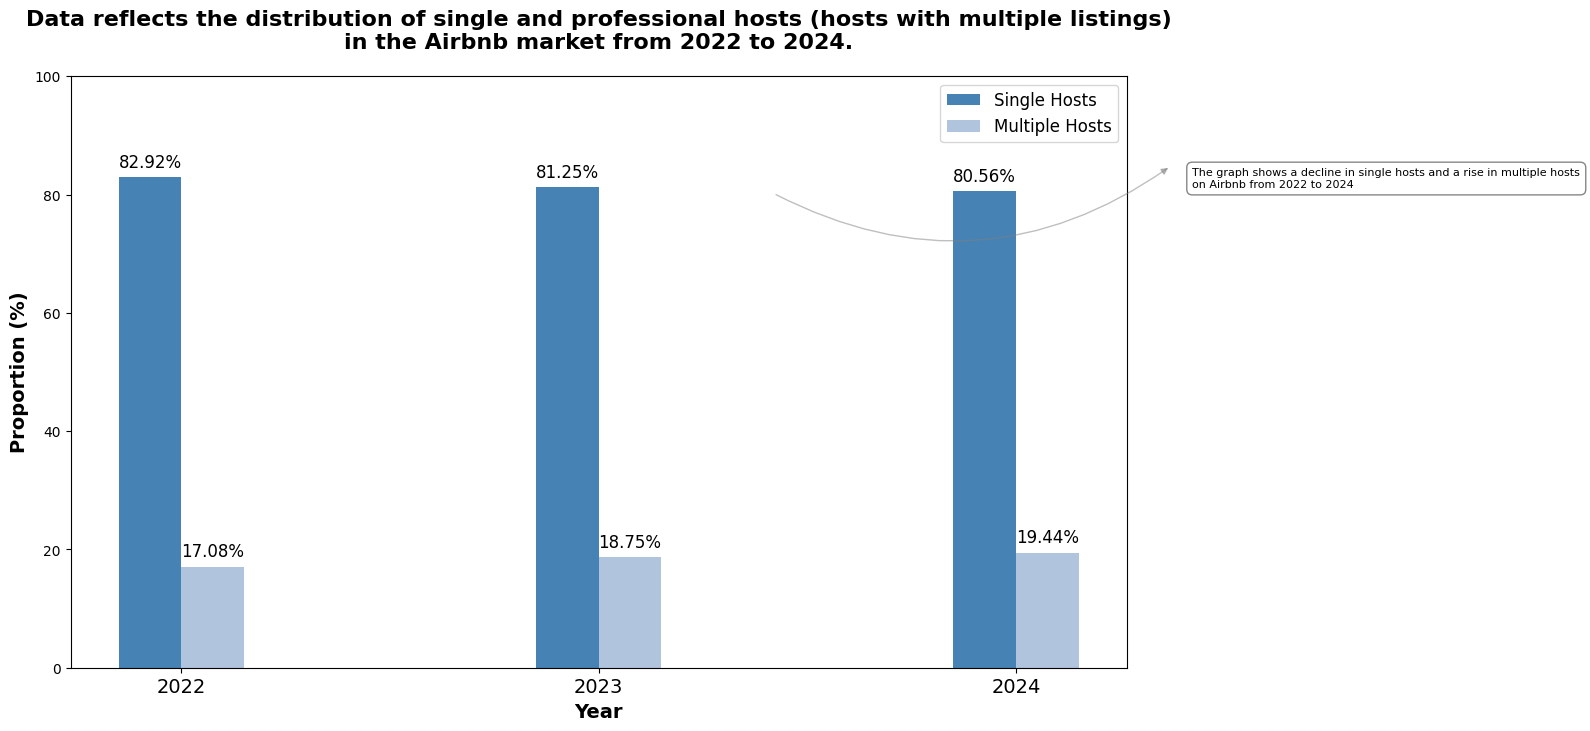

In [54]:
# Calculate host proportions for all years
single_hosts_proportions = []
multiple_hosts_proportions = []
years = ["2022", "2023", "2024"]

# Function to calculate host proportions based on host_id
def calculate_host_proportions(df):
    host_counts = df['host_id'].value_counts()
    single_hosts = (host_counts == 1).sum() / len(host_counts) * 100
    multiple_hosts = (host_counts > 1).sum() / len(host_counts) * 100
    return single_hosts, multiple_hosts

# Process DataFrames directly
dfs = [df_2022, df_2023, df_2024]
for df in dfs:
    single_prop, multiple_prop = calculate_host_proportions(df)
    single_hosts_proportions.append(single_prop)
    multiple_hosts_proportions.append(multiple_prop)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

# Bar positions and width
bar_width = 0.15  # Adjusted bar width for thinner rectangles
index = range(len(years))

# Plot bars for single and multiple hosts
bar1 = ax.bar(index, single_hosts_proportions, bar_width, label='Single Hosts', color='#4682B4')
bar2 = ax.bar([i + bar_width for i in index], multiple_hosts_proportions, bar_width, label='Multiple Hosts', color='#B0C4DE')

# Customize the plot
ax.set_xlabel('Year', fontsize=14, weight='bold', color='black')
ax.set_ylabel('Proportion (%)', fontsize=14, weight='bold', color='black')
ax.set_title('Data reflects the distribution of single and professional hosts (hosts with multiple listings)\nin the Airbnb market from 2022 to 2024.', fontsize=16, weight='bold', color='black', pad=20)
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(years, fontsize=14, color='black')

# Add percentage labels on top of the bars
for bar in bar1 + bar2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom', fontsize=12, color='black')

# Customize axis appearance
ax.tick_params(axis='both', which='both', colors='black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

# Adjust y-axis limit
ax.set_ylim(0, 100)

# Set background colors
fig.set_facecolor('white')
ax.set_facecolor('white')

# Add explanation box detached from the graph
explanation_text = (
    "The graph shows a decline in single hosts and a rise in multiple hosts\n"
    "on Airbnb from 2022 to 2024"
)
props = dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='gray', lw=1, alpha=0.95)
fig.text(1.02, 0.8, explanation_text, fontsize=8, bbox=props, verticalalignment='top', horizontalalignment='left')

# Add a lighter curved arrow to connect the plot to the explanation box
from matplotlib.patches import ConnectionPatch
arrow = ConnectionPatch(
    xyA=(1.5, 80), coordsA=ax.transData,  # Start point (data coordinates)
    xyB=(1, 0.8), coordsB=fig.transFigure,  # End point (figure coordinates)
    arrowstyle='-|>', connectionstyle="arc3,rad=0.3", color='gray', linewidth=1, alpha=0.5
)
fig.add_artist(arrow)

# Add legend and show the plot
ax.legend(fontsize=12, loc='upper right')
plt.tight_layout(pad=3)
plt.subplots_adjust(bottom=0.3)  # Reserve extra space for the footer
plt.show()

